In [3]:
%matplotlib inline
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torchgp.symbolic import *
from torchgp.transforms import *
from torchgp.reparameterization import *
from torchgp.test_tools import *
from torchgp.kernels import *
from torchgp.parameterizations.whitened import *
from torchgp.parameterizations.structured import Symmetric2DVector, UnconstrainedLowerTriangular
from torchgp.test_tools import *
from torchgp.structure import rkr_mv
import math
import networkx as nx
from matplotlib.pyplot import *

## Example 1

1. Sum of two linear GPMM signals from two independent SASE sources
2. Gaussian likelihood
3. MC for evaluation of variational expectation
4. Both signals share the same f axis


In [6]:
data_gen = TwoSASE1DSignals(50, 60, 200)
ya, yb, X, Z = data_gen.make_fake_data(100000)
yc = ya/2 + yb/2 + torch.randn(100000,1)/10

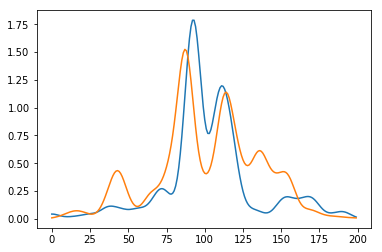

In [7]:
figure()
plot((data_gen.mean_A()/data_gen.n_A).numpy())
plot((data_gen.mean_B()/data_gen.n_B).numpy())

In [10]:
class VFE_1D_GPMM_Chained(torch.nn.Module):
    def __init__(self, U0, U1, F, Ntotal, Nmc = 100, std_lik_init = 0.5, lenscale_init = 0.05,
                 dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        f = Vector('f')
        m0 = Vector('m0')
        L0 = Matrix('L0')
        u0 = Vector('u0')
        K0 = Kernel('K0')
        m1 = Vector('m1')
        L1 = Matrix('L1')
        u1 = Vector('u1')
        K1 = Kernel('K1')
        y = Vector('y')
        X0 = Matrix('X0')
        X1 = Matrix('X1')
        Ntotal = Constant(Ntotal)
        Nmc = Constant(Nmc)
        #and finally the standard deviation of the likelihood
        std_lik = Scalar('std_lik')
        jitter = Scalar('jitter')
        #generally there are parameters which require positivity. I use this transform for them:
        self._makepos = SoftplusTransform()
        
        ### KL loss graph ###
        kl_loss = kl_1D(K0, u0, L0, m0, jitter) + kl_1D(K1, u1, L1, m1, jitter)
        self._kl_loss_expr = kl_loss
        graph = expr2graph(Label(String("kl_loss"), kl_loss))
        self._kl_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to weighted f-space ###
        m0f = weighted_1D_mean(K0, u0, f, m0, X0)
        m1f = weighted_1D_mean(K1, u1, f, m1, X1)
        var0f = weighted_var_1D_diag(K0, u0, f, L0, X0, jitter)
        var1f = weighted_var_1D_diag(K1, u1, f, L1, X1, jitter)
        
        ### Gaussian Likelihood in f-space ###
        ϵ0 = StdNormalSample(m0f,Nmc)
        ϵ1 = StdNormalSample(m1f,Nmc)
        z0 = Sqrt(var0f)*ϵ0 + m0f
        z1 = Sqrt(var1f)*ϵ1 + m1f
        z = z0 + z1
        ve_loss = gaussian_likelihood(y, z, std_lik, Ntotal)
        self._ve_loss_expr = ve_loss
        graph = expr2graph(Label(String("ve_loss"), ve_loss))
        self._ve_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #form the total loss
        loss = -ve_loss + kl_loss
        graph = expr2graph(Label(String("loss"), loss))
        self._loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to f-space ###
        m0f = mean_1D(K0, u0, f, m0)
        m1f = mean_1D(K1, u1, f, m1)
        graph = expr2graph(Label(String("mean0_pred"), m0f))
        self._mean0_pred = graph2ast(graph, compiled=True, debug=False)
        graph = expr2graph(Label(String("mean1_pred"), m1f))
        self._mean1_pred = graph2ast(graph, compiled=True, debug=False)
        var0f = var_1D_diag(K0, u0, f, L0, jitter)
        var1f = var_1D_diag(K1, u1, f, L1, jitter)
        graph = expr2graph(Label(String("var0_pred"), var0f))
        self._var0_pred = graph2ast(graph, compiled=True, debug=False)
        graph = expr2graph(Label(String("var1_pred"), var1f))
        self._var1_pred = graph2ast(graph, compiled=True, debug=False)
        
        
        #the actual storage tensors go here:
        with torch.no_grad():
            self.variational_params = torch.nn.ParameterDict({
                'm0': torch.nn.Parameter(torch.randn((U0,1),dtype=self.dtype)/(U0)),
                'm1': torch.nn.Parameter(torch.randn((U1,1),dtype=self.dtype)/(U1)),
            })
            self.hyper_params = torch.nn.ParameterDict({
                'std_lik': torch.nn.Parameter(self._makepos.inv(torch.tensor([[std_lik_init]],dtype=self.dtype))),
                'u0': torch.nn.Parameter(torch.linspace(-1,1,U0,dtype=self.dtype).unsqueeze(1)),
                'u1': torch.nn.Parameter(torch.linspace(-1,1,U1,dtype=self.dtype).unsqueeze(1)),
                #fixed parameters go here:
                'jitter': torch.nn.Parameter(torch.tensor(1e-4,dtype=self.dtype), requires_grad=False),
                'f': torch.nn.Parameter(torch.linspace(-1,1,F,dtype=self.dtype).unsqueeze(1), requires_grad=False),
            })

            #modules containing parameters go here:
            self.stored_K = torch.nn.ModuleDict({
                'K0': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]]), transforms=[self._makepos, self._makepos]),
                'K1': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]]), transforms=[self._makepos, self._makepos]),
                })
            self.L0 = UnconstrainedLowerTriangular(U0)
            self.L1 = UnconstrainedLowerTriangular(U1)
    def kl_loss(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'L0': self.L0(),
            'L1': self.L1(),
        }
        result = self._kl_loss_fun(**leaves)
        return result.kl_loss
    def ve_loss(self, y, X0, X1):
        leaves = {
            'y': y,
            'X0': X0,
            'X1': X1,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'L0': self.L0(),
            'L1': self.L1(),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._ve_loss_fun(**leaves)
        return result.ve_loss
    def loss(self, y, X0, X1):
        leaves = {
            'y': y,
            'X0': X0,
            'X1': X1,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'L0': self.L0(),
            'L1': self.L1(),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._loss_fun(**leaves)
        return result.loss
    def predict_mean0(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'L0': self.L0(),
            'L1': self.L1(),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._mean0_pred(**leaves)
        return result.mean0_pred
    def predict_var0(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'L0': self.L0(),
            'L1': self.L1(),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._var0_pred(**leaves)
        return result.var0_pred
    def predict_mean1(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'L0': self.L0(),
            'L1': self.L1(),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._mean1_pred(**leaves)
        return result.mean1_pred
    def predict_var1(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'L0': self.L0(),
            'L1': self.L1(),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._var1_pred(**leaves)
        return result.var1_pred

In [11]:
m = VFE_1D_GPMM_Chained(50,50,200,100000,std_lik_init=2.0,lenscale_init=0.05)
m.cuda()
optimizer = torch.optim.Adam(m.parameters(),lr=1e-2)
epochs = 2000
scheduler = StepLR(optimizer,50,gamma=0.95)

data = TensorDataset(X,Z,yc)
Logger = ScalarLogger(m, {'hyper_params.std_lik': m._makepos,
                          'stored_K.K0._lengthscale_storage': m._makepos,
                          'stored_K.K0._amplitude_storage': m._makepos,
                          'stored_K.K1._lengthscale_storage': m._makepos,
                          'stored_K.K1._amplitude_storage': m._makepos},
                     extra_keys={'loss': lambda x: x,
                                'step_size': lambda x: x})

for i in range(epochs):
    d = DataLoader(dataset=data, shuffle=True, batch_size=5000)
    for Xb,Zb,yb in d:
        ybc, Xbc, Zbc = yb.cuda(), Xb.cuda(), Zb.cuda()
        optimizer.zero_grad()
        loss = m.loss(ybc,Xbc,Zbc)
        loss.backward()
        optimizer.step()
        Logger(extra_vals=[float(loss), float(optimizer.param_groups[0]['lr'])])
    scheduler.step()
    print(Logger.report("epoch {:d}: ".format(i)))

epoch 0: hyper_params.std_lik: 1.82429, stored_K.K0._lengthscale_storage: 0.0478187, stored_K.K0._amplitude_storage: 0.952465, stored_K.K1._lengthscale_storage: 0.0482482, stored_K.K1._amplitude_storage: 0.958261, loss: 154277, step_size: 0.01, 
epoch 1: hyper_params.std_lik: 1.64879, stored_K.K0._lengthscale_storage: 0.0460037, stored_K.K0._amplitude_storage: 0.912649, stored_K.K1._lengthscale_storage: 0.0465447, stored_K.K1._amplitude_storage: 0.919335, loss: 143337, step_size: 0.01, 
epoch 2: hyper_params.std_lik: 1.47748, stored_K.K0._lengthscale_storage: 0.0458313, stored_K.K0._amplitude_storage: 0.891935, stored_K.K1._lengthscale_storage: 0.0463987, stored_K.K1._amplitude_storage: 0.898226, loss: 132402, step_size: 0.01, 
epoch 3: hyper_params.std_lik: 1.31132, stored_K.K0._lengthscale_storage: 0.0463023, stored_K.K0._amplitude_storage: 0.875926, stored_K.K1._lengthscale_storage: 0.0468631, stored_K.K1._amplitude_storage: 0.882668, loss: 120540, step_size: 0.01, 
epoch 4: hyper_p

epoch 33: hyper_params.std_lik: 0.100258, stored_K.K0._lengthscale_storage: 0.055547, stored_K.K0._amplitude_storage: 0.609772, stored_K.K1._lengthscale_storage: 0.0584328, stored_K.K1._amplitude_storage: 0.606596, loss: -88893, step_size: 0.01, 
epoch 34: hyper_params.std_lik: 0.100181, stored_K.K0._lengthscale_storage: 0.055526, stored_K.K0._amplitude_storage: 0.609688, stored_K.K1._lengthscale_storage: 0.058387, stored_K.K1._amplitude_storage: 0.606353, loss: -86358.9, step_size: 0.01, 
epoch 35: hyper_params.std_lik: 0.100236, stored_K.K0._lengthscale_storage: 0.0554464, stored_K.K0._amplitude_storage: 0.608965, stored_K.K1._lengthscale_storage: 0.0583402, stored_K.K1._amplitude_storage: 0.605892, loss: -87272.4, step_size: 0.01, 
epoch 36: hyper_params.std_lik: 0.100165, stored_K.K0._lengthscale_storage: 0.0554578, stored_K.K0._amplitude_storage: 0.609305, stored_K.K1._lengthscale_storage: 0.0582769, stored_K.K1._amplitude_storage: 0.605325, loss: -87954, step_size: 0.01, 
epoch 3

epoch 66: hyper_params.std_lik: 0.100085, stored_K.K0._lengthscale_storage: 0.0542738, stored_K.K0._amplitude_storage: 0.59656, stored_K.K1._lengthscale_storage: 0.0571685, stored_K.K1._amplitude_storage: 0.592297, loss: -88040.1, step_size: 0.0095, 
epoch 67: hyper_params.std_lik: 0.100094, stored_K.K0._lengthscale_storage: 0.0542549, stored_K.K0._amplitude_storage: 0.596245, stored_K.K1._lengthscale_storage: 0.0571598, stored_K.K1._amplitude_storage: 0.591934, loss: -89661.2, step_size: 0.0095, 
epoch 68: hyper_params.std_lik: 0.100133, stored_K.K0._lengthscale_storage: 0.054296, stored_K.K0._amplitude_storage: 0.596307, stored_K.K1._lengthscale_storage: 0.0572197, stored_K.K1._amplitude_storage: 0.592231, loss: -87396.4, step_size: 0.0095, 
epoch 69: hyper_params.std_lik: 0.100076, stored_K.K0._lengthscale_storage: 0.0542634, stored_K.K0._amplitude_storage: 0.595948, stored_K.K1._lengthscale_storage: 0.0571264, stored_K.K1._amplitude_storage: 0.591367, loss: -85981.8, step_size: 0.0

epoch 99: hyper_params.std_lik: 0.100273, stored_K.K0._lengthscale_storage: 0.0539411, stored_K.K0._amplitude_storage: 0.585983, stored_K.K1._lengthscale_storage: 0.0566297, stored_K.K1._amplitude_storage: 0.582318, loss: -89594.9, step_size: 0.0095, 
epoch 100: hyper_params.std_lik: 0.10038, stored_K.K0._lengthscale_storage: 0.053887, stored_K.K0._amplitude_storage: 0.585258, stored_K.K1._lengthscale_storage: 0.0565252, stored_K.K1._amplitude_storage: 0.581372, loss: -88698, step_size: 0.0095, 
epoch 101: hyper_params.std_lik: 0.100013, stored_K.K0._lengthscale_storage: 0.0538264, stored_K.K0._amplitude_storage: 0.584538, stored_K.K1._lengthscale_storage: 0.0564689, stored_K.K1._amplitude_storage: 0.580677, loss: -87840.4, step_size: 0.009025, 
epoch 102: hyper_params.std_lik: 0.100119, stored_K.K0._lengthscale_storage: 0.053866, stored_K.K0._amplitude_storage: 0.584519, stored_K.K1._lengthscale_storage: 0.0564932, stored_K.K1._amplitude_storage: 0.580751, loss: -87923.1, step_size: 0

epoch 132: hyper_params.std_lik: 0.100365, stored_K.K0._lengthscale_storage: 0.0534226, stored_K.K0._amplitude_storage: 0.573888, stored_K.K1._lengthscale_storage: 0.0559575, stored_K.K1._amplitude_storage: 0.571135, loss: -88720.8, step_size: 0.009025, 
epoch 133: hyper_params.std_lik: 0.099987, stored_K.K0._lengthscale_storage: 0.0533692, stored_K.K0._amplitude_storage: 0.573413, stored_K.K1._lengthscale_storage: 0.0559301, stored_K.K1._amplitude_storage: 0.57084, loss: -87459.7, step_size: 0.009025, 
epoch 134: hyper_params.std_lik: 0.10031, stored_K.K0._lengthscale_storage: 0.0534383, stored_K.K0._amplitude_storage: 0.573717, stored_K.K1._lengthscale_storage: 0.0558966, stored_K.K1._amplitude_storage: 0.570333, loss: -89558.9, step_size: 0.009025, 
epoch 135: hyper_params.std_lik: 0.100089, stored_K.K0._lengthscale_storage: 0.0533872, stored_K.K0._amplitude_storage: 0.57304, stored_K.K1._lengthscale_storage: 0.0559635, stored_K.K1._amplitude_storage: 0.570753, loss: -87551.6, step_

epoch 165: hyper_params.std_lik: 0.0997744, stored_K.K0._lengthscale_storage: 0.0533281, stored_K.K0._amplitude_storage: 0.565758, stored_K.K1._lengthscale_storage: 0.0556558, stored_K.K1._amplitude_storage: 0.562705, loss: -86417.8, step_size: 0.00857375, 
epoch 166: hyper_params.std_lik: 0.100276, stored_K.K0._lengthscale_storage: 0.0533419, stored_K.K0._amplitude_storage: 0.565535, stored_K.K1._lengthscale_storage: 0.0557737, stored_K.K1._amplitude_storage: 0.563504, loss: -85731.9, step_size: 0.00857375, 
epoch 167: hyper_params.std_lik: 0.100046, stored_K.K0._lengthscale_storage: 0.0532683, stored_K.K0._amplitude_storage: 0.564805, stored_K.K1._lengthscale_storage: 0.0556267, stored_K.K1._amplitude_storage: 0.5621, loss: -87111.3, step_size: 0.00857375, 
epoch 168: hyper_params.std_lik: 0.100241, stored_K.K0._lengthscale_storage: 0.0533288, stored_K.K0._amplitude_storage: 0.564967, stored_K.K1._lengthscale_storage: 0.0556485, stored_K.K1._amplitude_storage: 0.562118, loss: -87143.

epoch 197: hyper_params.std_lik: 0.100437, stored_K.K0._lengthscale_storage: 0.0532182, stored_K.K0._amplitude_storage: 0.557399, stored_K.K1._lengthscale_storage: 0.0555205, stored_K.K1._amplitude_storage: 0.55556, loss: -87967.3, step_size: 0.00857375, 
epoch 198: hyper_params.std_lik: 0.0999578, stored_K.K0._lengthscale_storage: 0.0532146, stored_K.K0._amplitude_storage: 0.557002, stored_K.K1._lengthscale_storage: 0.0554309, stored_K.K1._amplitude_storage: 0.554691, loss: -86381.5, step_size: 0.00857375, 
epoch 199: hyper_params.std_lik: 0.100272, stored_K.K0._lengthscale_storage: 0.0531746, stored_K.K0._amplitude_storage: 0.556387, stored_K.K1._lengthscale_storage: 0.055497, stored_K.K1._amplitude_storage: 0.555043, loss: -86705.9, step_size: 0.00857375, 
epoch 200: hyper_params.std_lik: 0.100024, stored_K.K0._lengthscale_storage: 0.0532334, stored_K.K0._amplitude_storage: 0.556686, stored_K.K1._lengthscale_storage: 0.0554547, stored_K.K1._amplitude_storage: 0.554469, loss: -89981.

epoch 229: hyper_params.std_lik: 0.100543, stored_K.K0._lengthscale_storage: 0.0530712, stored_K.K0._amplitude_storage: 0.549164, stored_K.K1._lengthscale_storage: 0.0552801, stored_K.K1._amplitude_storage: 0.547982, loss: -89001.2, step_size: 0.00814506, 
epoch 230: hyper_params.std_lik: 0.0997074, stored_K.K0._lengthscale_storage: 0.0531136, stored_K.K0._amplitude_storage: 0.549106, stored_K.K1._lengthscale_storage: 0.0553635, stored_K.K1._amplitude_storage: 0.54844, loss: -87890.4, step_size: 0.00814506, 
epoch 231: hyper_params.std_lik: 0.100293, stored_K.K0._lengthscale_storage: 0.0530619, stored_K.K0._amplitude_storage: 0.548655, stored_K.K1._lengthscale_storage: 0.0552879, stored_K.K1._amplitude_storage: 0.547703, loss: -87811.9, step_size: 0.00814506, 
epoch 232: hyper_params.std_lik: 0.100045, stored_K.K0._lengthscale_storage: 0.0530949, stored_K.K0._amplitude_storage: 0.548538, stored_K.K1._lengthscale_storage: 0.0552511, stored_K.K1._amplitude_storage: 0.54714, loss: -86928.

epoch 261: hyper_params.std_lik: 0.0995473, stored_K.K0._lengthscale_storage: 0.052918, stored_K.K0._amplitude_storage: 0.541135, stored_K.K1._lengthscale_storage: 0.0550421, stored_K.K1._amplitude_storage: 0.539757, loss: -87949.9, step_size: 0.00773781, 
epoch 262: hyper_params.std_lik: 0.0998765, stored_K.K0._lengthscale_storage: 0.0529018, stored_K.K0._amplitude_storage: 0.540804, stored_K.K1._lengthscale_storage: 0.0551447, stored_K.K1._amplitude_storage: 0.540414, loss: -87983.7, step_size: 0.00773781, 
epoch 263: hyper_params.std_lik: 0.0996568, stored_K.K0._lengthscale_storage: 0.0529438, stored_K.K0._amplitude_storage: 0.540921, stored_K.K1._lengthscale_storage: 0.0550427, stored_K.K1._amplitude_storage: 0.539524, loss: -88062.9, step_size: 0.00773781, 
epoch 264: hyper_params.std_lik: 0.100112, stored_K.K0._lengthscale_storage: 0.0529205, stored_K.K0._amplitude_storage: 0.54053, stored_K.K1._lengthscale_storage: 0.0550779, stored_K.K1._amplitude_storage: 0.539605, loss: -8864

epoch 293: hyper_params.std_lik: 0.100049, stored_K.K0._lengthscale_storage: 0.0528328, stored_K.K0._amplitude_storage: 0.533813, stored_K.K1._lengthscale_storage: 0.0549693, stored_K.K1._amplitude_storage: 0.533483, loss: -86584.8, step_size: 0.00773781, 
epoch 294: hyper_params.std_lik: 0.0998824, stored_K.K0._lengthscale_storage: 0.0527728, stored_K.K0._amplitude_storage: 0.533181, stored_K.K1._lengthscale_storage: 0.0549508, stored_K.K1._amplitude_storage: 0.533211, loss: -88709.9, step_size: 0.00773781, 
epoch 295: hyper_params.std_lik: 0.100388, stored_K.K0._lengthscale_storage: 0.05285, stored_K.K0._amplitude_storage: 0.533333, stored_K.K1._lengthscale_storage: 0.0548843, stored_K.K1._amplitude_storage: 0.532532, loss: -87817.7, step_size: 0.00773781, 
epoch 296: hyper_params.std_lik: 0.10034, stored_K.K0._lengthscale_storage: 0.0527738, stored_K.K0._amplitude_storage: 0.532511, stored_K.K1._lengthscale_storage: 0.0548813, stored_K.K1._amplitude_storage: 0.53218, loss: -86809.7,

epoch 325: hyper_params.std_lik: 0.0999751, stored_K.K0._lengthscale_storage: 0.0527985, stored_K.K0._amplitude_storage: 0.527172, stored_K.K1._lengthscale_storage: 0.0548122, stored_K.K1._amplitude_storage: 0.526815, loss: -87339.5, step_size: 0.00735092, 
epoch 326: hyper_params.std_lik: 0.100017, stored_K.K0._lengthscale_storage: 0.0527534, stored_K.K0._amplitude_storage: 0.526741, stored_K.K1._lengthscale_storage: 0.0548676, stored_K.K1._amplitude_storage: 0.527105, loss: -89188.6, step_size: 0.00735092, 
epoch 327: hyper_params.std_lik: 0.100798, stored_K.K0._lengthscale_storage: 0.0527713, stored_K.K0._amplitude_storage: 0.526507, stored_K.K1._lengthscale_storage: 0.0548799, stored_K.K1._amplitude_storage: 0.527034, loss: -86771.2, step_size: 0.00735092, 
epoch 328: hyper_params.std_lik: 0.0993677, stored_K.K0._lengthscale_storage: 0.0527758, stored_K.K0._amplitude_storage: 0.526375, stored_K.K1._lengthscale_storage: 0.0548366, stored_K.K1._amplitude_storage: 0.526566, loss: -887

epoch 357: hyper_params.std_lik: 0.100846, stored_K.K0._lengthscale_storage: 0.0527567, stored_K.K0._amplitude_storage: 0.520816, stored_K.K1._lengthscale_storage: 0.0548038, stored_K.K1._amplitude_storage: 0.521367, loss: -89330.7, step_size: 0.00698337, 
epoch 358: hyper_params.std_lik: 0.100707, stored_K.K0._lengthscale_storage: 0.0527789, stored_K.K0._amplitude_storage: 0.520756, stored_K.K1._lengthscale_storage: 0.0547756, stored_K.K1._amplitude_storage: 0.520929, loss: -88085.3, step_size: 0.00698337, 
epoch 359: hyper_params.std_lik: 0.100184, stored_K.K0._lengthscale_storage: 0.052763, stored_K.K0._amplitude_storage: 0.520483, stored_K.K1._lengthscale_storage: 0.0547743, stored_K.K1._amplitude_storage: 0.520794, loss: -89555.5, step_size: 0.00698337, 
epoch 360: hyper_params.std_lik: 0.100269, stored_K.K0._lengthscale_storage: 0.0528015, stored_K.K0._amplitude_storage: 0.520704, stored_K.K1._lengthscale_storage: 0.0547948, stored_K.K1._amplitude_storage: 0.520802, loss: -87272.

KeyboardInterrupt: 

In [12]:
m.cpu()

VFE_1D_GPMM_Chained(
  (variational_params): ParameterDict(
      (m0): Parameter containing: [torch.FloatTensor of size 50x1]
      (m1): Parameter containing: [torch.FloatTensor of size 50x1]
  )
  (hyper_params): ParameterDict(
      (f): Parameter containing: [torch.FloatTensor of size 200x1]
      (jitter): Parameter containing: [torch.FloatTensor of size ]
      (std_lik): Parameter containing: [torch.FloatTensor of size 1x1]
      (u0): Parameter containing: [torch.FloatTensor of size 50x1]
      (u1): Parameter containing: [torch.FloatTensor of size 50x1]
  )
  (stored_K): ModuleDict(
    (K0): ARDRBFKernel(lengthscale=tensor([[0.0528]]), amplitude=0.5201014876365662)
    (K1): ARDRBFKernel(lengthscale=tensor([[0.0548]]), amplitude=0.5204631686210632)
  )
  (L0): UnconstrainedLowerTriangular()
  (L1): UnconstrainedLowerTriangular()
)

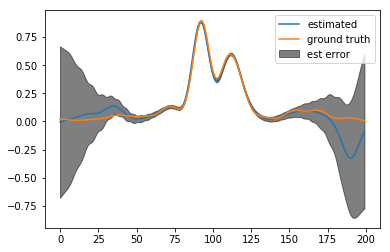

In [13]:
figure()
μ = m.predict_mean0().detach().squeeze().numpy()
σ = m.predict_var0().detach().sqrt().squeeze().numpy()
plot(μ, label='estimated')
fill_between(np.arange(200),μ+σ,μ-σ,color='k',alpha=0.5,label='est error')
plot((data_gen.mean_A()/data_gen.n_A).numpy()/2,label='ground truth')
legend()

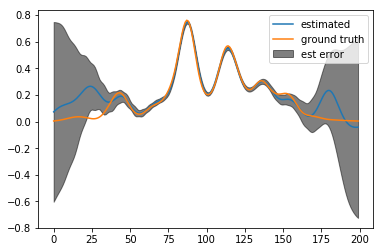

In [14]:
figure()
μ = m.predict_mean1().detach().squeeze().numpy()
σ = m.predict_var1().detach().sqrt().squeeze().numpy()
plot(μ, label='estimated')
fill_between(np.arange(200),μ+σ,μ-σ,color='k',alpha=0.5,label='est error')
plot((data_gen.mean_B()/data_gen.n_B).numpy()/2,label='ground truth')
legend()

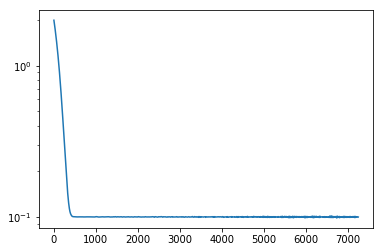

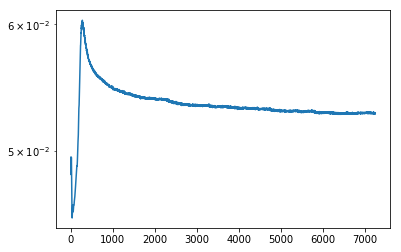

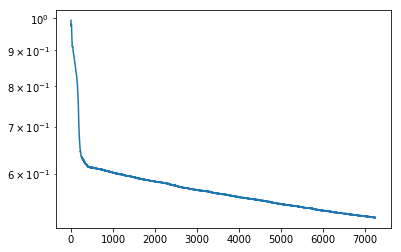

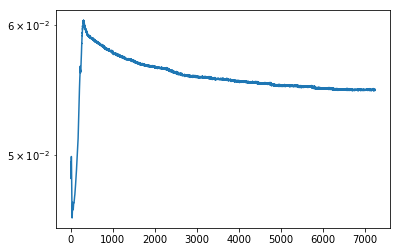

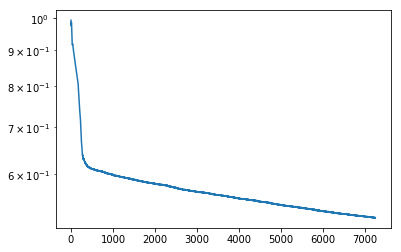

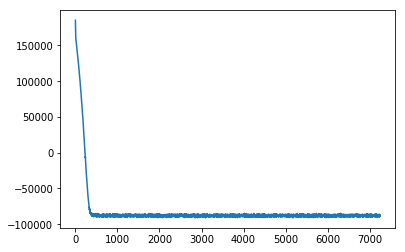

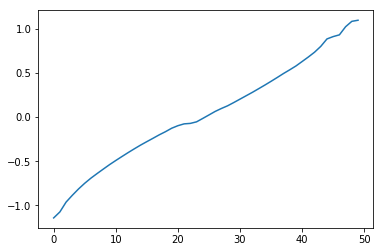

In [15]:
figure()
semilogy(Logger.val_dict['hyper_params.std_lik'])
figure()
semilogy(Logger.val_dict['stored_K.K0._lengthscale_storage'])
figure()
semilogy(Logger.val_dict['stored_K.K0._amplitude_storage'])
figure()
semilogy(Logger.val_dict['stored_K.K1._lengthscale_storage'])
figure()
semilogy(Logger.val_dict['stored_K.K1._amplitude_storage'])
figure()
plot(Logger.val_dict['loss'])
figure()
plot(np.sort(m.hyper_params['u0'].detach().numpy().squeeze()))

## Example 2

1. Sum of 1 linear signal and 1 quadratic signal from identical SASE source
2. single pixel detector
2. Shared f axis for SASE source among both signals
2. Symmetric mean function for quadratic signal
2. Gaussian likelihood
3. MC for evaluation of variational expectation

In [16]:
data_gen2 = NonlinearAndLinear(50,50,200)

In [17]:
y0, y1, X = data_gen2.make_fake_data(100000)
yc = y0/2 + y1/2 + torch.randn(100000,1)/10

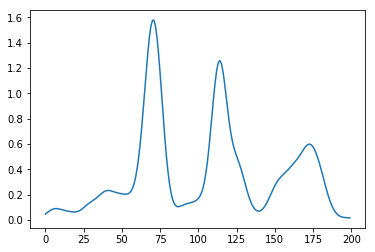

In [18]:
figure()
plot((data_gen2.mean_A()/data_gen2.n_A).numpy())

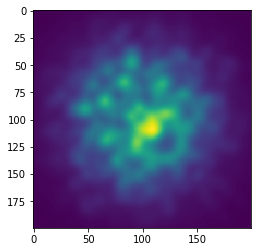

In [19]:
figure()
imshow((data_gen2.mean_B()/data_gen2.n_B).numpy())

In [24]:
class VFE_2D_GPMM_Chained(torch.nn.Module):
    def __init__(self, U0, U1, F, Ntotal, Nmc = 100, std_lik_init = 0.5, lenscale_init = 0.05,
                 dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        f = Vector('f')
        m0 = Vector('m0')
        L0 = Matrix('L0')
        u0 = Vector('u0')
        K0 = Kernel('K0')
        m1 = Vector('m1')
        L1 = Matrix('L1')
        u1 = Vector('u1')
        K1 = Kernel('K1')
        y = Vector('y')
        X = Matrix('X')
        Ntotal = Constant(Ntotal)
        Nmc = Constant(Nmc)
        #and finally the standard deviation of the likelihood
        std_lik = Scalar('std_lik')
        jitter = Scalar('jitter')
        #generally there are parameters which require positivity. I use this transform for them:
        self._makepos = SoftplusTransform()
        
        ### KL loss graph ###
        kl_loss = kl_1D(K0, u0, L0, m0, jitter) + kl_2D(K1, K1, u1, u1, L1, L1, m1, jitter)
        self._kl_loss_expr = kl_loss
        graph = expr2graph(Label(String("kl_loss"), kl_loss))
        self._kl_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to weighted f-space ###
        m0f = weighted_1D_mean(K0, u0, f, m0, X)
        m1f = fully_weighted_2D_mean(K1, K1, u1, u1, f, f, m1, X, X)
        var0f = weighted_var_1D_diag(K0, u0, f, L0, X, jitter)
        
        t1 = weighted_var_fullspace_diag(K1, f, X) * weighted_var_fullspace_diag(K1, f, X)
        t2 = weighted_var_subspace_diag(K1, u1, f, X, jitter) * weighted_var_subspace_diag(K1, u1, f, X, jitter)
        t3 = weighted_var_posterior_diag(K1, u1, f, L1, X, jitter) * weighted_var_posterior_diag(K1, u1, f, L1, X, jitter)
        var1f = t1 - t2 + t3
    
        
        ### Gaussian Likelihood in f-space ###
        ϵ0 = StdNormalSample(m0f,Nmc)
        ϵ1 = StdNormalSample(m1f,Nmc)
        z0 = Sqrt(var0f)*ϵ0 + m0f
        z1 = Sqrt(var1f)*ϵ1 + m1f
        z = z0 + z1
        ve_loss = gaussian_likelihood(y, z, std_lik, Ntotal)
        self._ve_loss_expr = ve_loss
        graph = expr2graph(Label(String("ve_loss"), ve_loss))
        self._ve_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #form the total loss
        loss = -ve_loss + kl_loss
        graph = expr2graph(Label(String("loss"), loss))
        self._loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to f-space ###
        m0f = mean_1D(K0, u0, f, m0)
        m1f = mean_2D(K1, K1, u1, u1, f, f, m1)
        graph = expr2graph(Label(String("mean0_pred"), m0f))
        self._mean0_pred = graph2ast(graph, compiled=True, debug=False)
        graph = expr2graph(Label(String("mean1_pred"), m1f))
        self._mean1_pred = graph2ast(graph, compiled=True, debug=False)
        var0f = var_1D_diag(K0, u0, f, L0, jitter)
        t1 = KroneckerProduct(var_fullspace_diag(K1, f), var_fullspace_diag(K1, f))
        t2 = KroneckerProduct(var_subspace_diag(K1, u1, f, jitter), var_subspace_diag(K1, u1, f, jitter))
        t3 = KroneckerProduct(var_posterior_diag(K1, u1, f, L1, jitter), var_posterior_diag(K1, u1, f, L1, jitter))
        var1f = t1 - t2 + t3
        graph = expr2graph(Label(String("var0_pred"), var0f))
        self._var0_pred = graph2ast(graph, compiled=True, debug=False)
        graph = expr2graph(Label(String("var1_pred"), var1f))
        self._var1_pred = graph2ast(graph, compiled=True, debug=False)
        
        #the actual storage tensors go here:
        with torch.no_grad():
            self.variational_params = torch.nn.ParameterDict({
                'm0': torch.nn.Parameter(torch.randn((U0,1),dtype=self.dtype)/(U0)),
            })
            self.hyper_params = torch.nn.ParameterDict({
                'std_lik': torch.nn.Parameter(self._makepos.inv(torch.tensor([[std_lik_init]],dtype=self.dtype))),
                'u0': torch.nn.Parameter(torch.linspace(-1,1,U0,dtype=self.dtype).unsqueeze(1)),
                'u1': torch.nn.Parameter(torch.linspace(-1,1,U1,dtype=self.dtype).unsqueeze(1)),
                #fixed parameters go here:
                'jitter': torch.nn.Parameter(torch.tensor(1e-4,dtype=self.dtype), requires_grad=False),
                'f': torch.nn.Parameter(torch.linspace(-1,1,F,dtype=self.dtype).unsqueeze(1), requires_grad=False),
            })

            #modules containing parameters go here:
            self.stored_K = torch.nn.ModuleDict({
                'K0': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]]), transforms=[self._makepos, self._makepos]),
                'K1': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]]), transforms=[self._makepos, self._makepos]),
                })
            self.m1 = Symmetric2DVector(U1)
            self.L0 = UnconstrainedLowerTriangular(U0)
            self.L1 = UnconstrainedLowerTriangular(U1)
    def kl_loss(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'L0': self.L0(),
            'L1': self.L1(),
            'm1': self.m1()
        }
        result = self._kl_loss_fun(**leaves)
        return result.kl_loss
    def ve_loss(self, y, X):
        leaves = {
            'y': y,
            'X': X,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'L0': self.L0(),
            'L1': self.L1(),
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'm1': self.m1()
        }
        result = self._ve_loss_fun(**leaves)
        return result.ve_loss
    def loss(self, y, X):
        leaves = {
            'y': y,
            'X': X,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'L0': self.L0(),
            'L1': self.L1(),
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'm1': self.m1()
        }
        result = self._loss_fun(**leaves)
        return result.loss
    def predict_mean0(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'L0': self.L0(),
            'L1': self.L1(),
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'm1': self.m1()
        }
        result = self._mean0_pred(**leaves)
        return result.mean0_pred
    def predict_var0(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'L0': self.L0(),
            'L1': self.L1(),
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'm1': self.m1()
        }
        result = self._var0_pred(**leaves)
        return result.var0_pred
    def predict_mean1(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'L0': self.L0(),
            'L1': self.L1(),
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'm1': self.m1()
        }
        result = self._mean1_pred(**leaves)
        return result.mean1_pred
    def predict_var1(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'L0': self.L0(),
            'L1': self.L1(),
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'm1': self.m1()
        }
        result = self._var1_pred(**leaves)
        return result.var1_pred

In [33]:
m = VFE_2D_GPMM_Chained(50,50,200,100000,std_lik_init=2.0,lenscale_init=0.05)
m.cuda()
optimizer = torch.optim.Adam(m.parameters(),lr=1e-2)
epochs = 2500
scheduler = StepLR(optimizer,150,gamma=0.95)

data = TensorDataset(X,yc)
Logger = ScalarLogger(m, {'hyper_params.std_lik': m._makepos,
                          'stored_K.K0._lengthscale_storage': m._makepos,
                          'stored_K.K0._amplitude_storage': m._makepos,
                          'stored_K.K1._lengthscale_storage': m._makepos,
                          'stored_K.K1._amplitude_storage': m._makepos},
                     extra_keys={'loss': lambda x: x,
                                'step_size': lambda x: x})

for i in range(epochs):
    d = DataLoader(dataset=data, shuffle=True, batch_size=5000)
    for Xb,yb in d:
        ybc, Xbc = yb.cuda(), Xb.cuda()
        optimizer.zero_grad()
        loss = m.loss(ybc,Xbc)
        loss.backward()
        optimizer.step()
        Logger(extra_vals=[float(loss), float(optimizer.param_groups[0]['lr'])])
    scheduler.step()
    print(Logger.report("epoch {:d}: ".format(i)))

epoch 0: hyper_params.std_lik: 1.8306, stored_K.K0._lengthscale_storage: 0.0459217, stored_K.K0._amplitude_storage: 0.929881, stored_K.K1._lengthscale_storage: 0.0455911, stored_K.K1._amplitude_storage: 0.938358, loss: 155171, step_size: 0.01, 
epoch 1: hyper_params.std_lik: 1.65232, stored_K.K0._lengthscale_storage: 0.0460029, stored_K.K0._amplitude_storage: 0.901638, stored_K.K1._lengthscale_storage: 0.0445272, stored_K.K1._amplitude_storage: 0.920919, loss: 143984, step_size: 0.01, 
epoch 2: hyper_params.std_lik: 1.47849, stored_K.K0._lengthscale_storage: 0.0462513, stored_K.K0._amplitude_storage: 0.875502, stored_K.K1._lengthscale_storage: 0.0443038, stored_K.K1._amplitude_storage: 0.915481, loss: 132673, step_size: 0.01, 
epoch 3: hyper_params.std_lik: 1.31059, stored_K.K0._lengthscale_storage: 0.0467976, stored_K.K0._amplitude_storage: 0.8481, stored_K.K1._lengthscale_storage: 0.0443595, stored_K.K1._amplitude_storage: 0.91369, loss: 120683, step_size: 0.01, 
epoch 4: hyper_param

epoch 33: hyper_params.std_lik: 0.102284, stored_K.K0._lengthscale_storage: 0.0566815, stored_K.K0._amplitude_storage: 0.583271, stored_K.K1._lengthscale_storage: 0.0445409, stored_K.K1._amplitude_storage: 0.688712, loss: -84671.9, step_size: 0.01, 
epoch 34: hyper_params.std_lik: 0.102759, stored_K.K0._lengthscale_storage: 0.0566748, stored_K.K0._amplitude_storage: 0.583151, stored_K.K1._lengthscale_storage: 0.0446303, stored_K.K1._amplitude_storage: 0.686994, loss: -84503, step_size: 0.01, 
epoch 35: hyper_params.std_lik: 0.102936, stored_K.K0._lengthscale_storage: 0.0566568, stored_K.K0._amplitude_storage: 0.582854, stored_K.K1._lengthscale_storage: 0.0447229, stored_K.K1._amplitude_storage: 0.685481, loss: -84983.4, step_size: 0.01, 
epoch 36: hyper_params.std_lik: 0.10255, stored_K.K0._lengthscale_storage: 0.0566525, stored_K.K0._amplitude_storage: 0.582781, stored_K.K1._lengthscale_storage: 0.0448314, stored_K.K1._amplitude_storage: 0.684303, loss: -87602.3, step_size: 0.01, 
epo

epoch 66: hyper_params.std_lik: 0.105124, stored_K.K0._lengthscale_storage: 0.0605888, stored_K.K0._amplitude_storage: 0.566865, stored_K.K1._lengthscale_storage: 0.0460183, stored_K.K1._amplitude_storage: 0.642855, loss: -85226.7, step_size: 0.01, 
epoch 67: hyper_params.std_lik: 0.10319, stored_K.K0._lengthscale_storage: 0.0605913, stored_K.K0._amplitude_storage: 0.566769, stored_K.K1._lengthscale_storage: 0.0460374, stored_K.K1._amplitude_storage: 0.641269, loss: -84904, step_size: 0.01, 
epoch 68: hyper_params.std_lik: 0.101753, stored_K.K0._lengthscale_storage: 0.0605669, stored_K.K0._amplitude_storage: 0.566624, stored_K.K1._lengthscale_storage: 0.0460885, stored_K.K1._amplitude_storage: 0.640096, loss: -83599.3, step_size: 0.01, 
epoch 69: hyper_params.std_lik: 0.101206, stored_K.K0._lengthscale_storage: 0.0605895, stored_K.K0._amplitude_storage: 0.566858, stored_K.K1._lengthscale_storage: 0.0461622, stored_K.K1._amplitude_storage: 0.63926, loss: -85244.7, step_size: 0.01, 
epoc

epoch 99: hyper_params.std_lik: 0.10138, stored_K.K0._lengthscale_storage: 0.059103, stored_K.K0._amplitude_storage: 0.556019, stored_K.K1._lengthscale_storage: 0.0462616, stored_K.K1._amplitude_storage: 0.592025, loss: -86659.6, step_size: 0.01, 
epoch 100: hyper_params.std_lik: 0.101397, stored_K.K0._lengthscale_storage: 0.0591226, stored_K.K0._amplitude_storage: 0.556221, stored_K.K1._lengthscale_storage: 0.0463347, stored_K.K1._amplitude_storage: 0.591258, loss: -87182.9, step_size: 0.01, 
epoch 101: hyper_params.std_lik: 0.10118, stored_K.K0._lengthscale_storage: 0.0591155, stored_K.K0._amplitude_storage: 0.556204, stored_K.K1._lengthscale_storage: 0.0463972, stored_K.K1._amplitude_storage: 0.590492, loss: -86153.5, step_size: 0.01, 
epoch 102: hyper_params.std_lik: 0.101603, stored_K.K0._lengthscale_storage: 0.0591315, stored_K.K0._amplitude_storage: 0.556328, stored_K.K1._lengthscale_storage: 0.046449, stored_K.K1._amplitude_storage: 0.589649, loss: -85891.4, step_size: 0.01, 
e

epoch 132: hyper_params.std_lik: 0.102036, stored_K.K0._lengthscale_storage: 0.0582808, stored_K.K0._amplitude_storage: 0.550517, stored_K.K1._lengthscale_storage: 0.0472981, stored_K.K1._amplitude_storage: 0.561478, loss: -84217.9, step_size: 0.01, 
epoch 133: hyper_params.std_lik: 0.101519, stored_K.K0._lengthscale_storage: 0.0583083, stored_K.K0._amplitude_storage: 0.550582, stored_K.K1._lengthscale_storage: 0.0473488, stored_K.K1._amplitude_storage: 0.560662, loss: -85806.8, step_size: 0.01, 
epoch 134: hyper_params.std_lik: 0.101257, stored_K.K0._lengthscale_storage: 0.0582343, stored_K.K0._amplitude_storage: 0.549858, stored_K.K1._lengthscale_storage: 0.0473545, stored_K.K1._amplitude_storage: 0.559532, loss: -85311, step_size: 0.01, 
epoch 135: hyper_params.std_lik: 0.101816, stored_K.K0._lengthscale_storage: 0.0582619, stored_K.K0._amplitude_storage: 0.55015, stored_K.K1._lengthscale_storage: 0.0474135, stored_K.K1._amplitude_storage: 0.558846, loss: -85515.9, step_size: 0.01, 

epoch 165: hyper_params.std_lik: 0.101187, stored_K.K0._lengthscale_storage: 0.0574408, stored_K.K0._amplitude_storage: 0.542831, stored_K.K1._lengthscale_storage: 0.0478762, stored_K.K1._amplitude_storage: 0.530576, loss: -86287.8, step_size: 0.0095, 
epoch 166: hyper_params.std_lik: 0.102047, stored_K.K0._lengthscale_storage: 0.0573575, stored_K.K0._amplitude_storage: 0.542244, stored_K.K1._lengthscale_storage: 0.0479294, stored_K.K1._amplitude_storage: 0.530105, loss: -86730.2, step_size: 0.0095, 
epoch 167: hyper_params.std_lik: 0.107851, stored_K.K0._lengthscale_storage: 0.0572237, stored_K.K0._amplitude_storage: 0.541115, stored_K.K1._lengthscale_storage: 0.047743, stored_K.K1._amplitude_storage: 0.527216, loss: -83558.2, step_size: 0.0095, 
epoch 168: hyper_params.std_lik: 0.102513, stored_K.K0._lengthscale_storage: 0.0572673, stored_K.K0._amplitude_storage: 0.541413, stored_K.K1._lengthscale_storage: 0.0476938, stored_K.K1._amplitude_storage: 0.525465, loss: -84319.5, step_size

epoch 198: hyper_params.std_lik: 0.102731, stored_K.K0._lengthscale_storage: 0.0566927, stored_K.K0._amplitude_storage: 0.535215, stored_K.K1._lengthscale_storage: 0.0483407, stored_K.K1._amplitude_storage: 0.503451, loss: -84469, step_size: 0.0095, 
epoch 199: hyper_params.std_lik: 0.100937, stored_K.K0._lengthscale_storage: 0.0566306, stored_K.K0._amplitude_storage: 0.534578, stored_K.K1._lengthscale_storage: 0.0483435, stored_K.K1._amplitude_storage: 0.502513, loss: -86596.6, step_size: 0.0095, 
epoch 200: hyper_params.std_lik: 0.10149, stored_K.K0._lengthscale_storage: 0.0567074, stored_K.K0._amplitude_storage: 0.535002, stored_K.K1._lengthscale_storage: 0.0483618, stored_K.K1._amplitude_storage: 0.501787, loss: -86140.7, step_size: 0.0095, 
epoch 201: hyper_params.std_lik: 0.100803, stored_K.K0._lengthscale_storage: 0.0566914, stored_K.K0._amplitude_storage: 0.53492, stored_K.K1._lengthscale_storage: 0.0483942, stored_K.K1._amplitude_storage: 0.501185, loss: -86062, step_size: 0.0

epoch 231: hyper_params.std_lik: 0.101247, stored_K.K0._lengthscale_storage: 0.0561294, stored_K.K0._amplitude_storage: 0.52702, stored_K.K1._lengthscale_storage: 0.048597, stored_K.K1._amplitude_storage: 0.476747, loss: -85104.6, step_size: 0.0095, 
epoch 232: hyper_params.std_lik: 0.101784, stored_K.K0._lengthscale_storage: 0.0559944, stored_K.K0._amplitude_storage: 0.525885, stored_K.K1._lengthscale_storage: 0.0486045, stored_K.K1._amplitude_storage: 0.475941, loss: -85395.3, step_size: 0.0095, 
epoch 233: hyper_params.std_lik: 0.100899, stored_K.K0._lengthscale_storage: 0.0560436, stored_K.K0._amplitude_storage: 0.526028, stored_K.K1._lengthscale_storage: 0.048658, stored_K.K1._amplitude_storage: 0.475486, loss: -86298.6, step_size: 0.0095, 
epoch 234: hyper_params.std_lik: 0.100874, stored_K.K0._lengthscale_storage: 0.0560399, stored_K.K0._amplitude_storage: 0.525811, stored_K.K1._lengthscale_storage: 0.048668, stored_K.K1._amplitude_storage: 0.474769, loss: -86463.9, step_size: 0

epoch 264: hyper_params.std_lik: 0.10207, stored_K.K0._lengthscale_storage: 0.0556363, stored_K.K0._amplitude_storage: 0.518292, stored_K.K1._lengthscale_storage: 0.0490106, stored_K.K1._amplitude_storage: 0.453851, loss: -86821.2, step_size: 0.0095, 
epoch 265: hyper_params.std_lik: 0.102868, stored_K.K0._lengthscale_storage: 0.0555257, stored_K.K0._amplitude_storage: 0.517519, stored_K.K1._lengthscale_storage: 0.0489909, stored_K.K1._amplitude_storage: 0.452952, loss: -82990.1, step_size: 0.0095, 
epoch 266: hyper_params.std_lik: 0.101526, stored_K.K0._lengthscale_storage: 0.0555717, stored_K.K0._amplitude_storage: 0.517392, stored_K.K1._lengthscale_storage: 0.0490188, stored_K.K1._amplitude_storage: 0.452017, loss: -85838.6, step_size: 0.0095, 
epoch 267: hyper_params.std_lik: 0.101667, stored_K.K0._lengthscale_storage: 0.0555969, stored_K.K0._amplitude_storage: 0.517223, stored_K.K1._lengthscale_storage: 0.0490527, stored_K.K1._amplitude_storage: 0.451372, loss: -85290.2, step_size

epoch 297: hyper_params.std_lik: 0.101178, stored_K.K0._lengthscale_storage: 0.0552909, stored_K.K0._amplitude_storage: 0.510669, stored_K.K1._lengthscale_storage: 0.0495321, stored_K.K1._amplitude_storage: 0.433896, loss: -86747.9, step_size: 0.0095, 
epoch 298: hyper_params.std_lik: 0.101388, stored_K.K0._lengthscale_storage: 0.0552946, stored_K.K0._amplitude_storage: 0.510545, stored_K.K1._lengthscale_storage: 0.0496005, stored_K.K1._amplitude_storage: 0.433711, loss: -87064.4, step_size: 0.0095, 
epoch 299: hyper_params.std_lik: 0.100878, stored_K.K0._lengthscale_storage: 0.0552775, stored_K.K0._amplitude_storage: 0.510243, stored_K.K1._lengthscale_storage: 0.0495969, stored_K.K1._amplitude_storage: 0.433008, loss: -84050.4, step_size: 0.0095, 
epoch 300: hyper_params.std_lik: 0.101422, stored_K.K0._lengthscale_storage: 0.0552609, stored_K.K0._amplitude_storage: 0.510015, stored_K.K1._lengthscale_storage: 0.0496089, stored_K.K1._amplitude_storage: 0.432446, loss: -86439.6, step_siz

epoch 330: hyper_params.std_lik: 0.101004, stored_K.K0._lengthscale_storage: 0.0549388, stored_K.K0._amplitude_storage: 0.503057, stored_K.K1._lengthscale_storage: 0.0498426, stored_K.K1._amplitude_storage: 0.415274, loss: -87751.8, step_size: 0.009025, 
epoch 331: hyper_params.std_lik: 0.101838, stored_K.K0._lengthscale_storage: 0.0549542, stored_K.K0._amplitude_storage: 0.502998, stored_K.K1._lengthscale_storage: 0.0498788, stored_K.K1._amplitude_storage: 0.414972, loss: -86300.7, step_size: 0.009025, 
epoch 332: hyper_params.std_lik: 0.100536, stored_K.K0._lengthscale_storage: 0.0549019, stored_K.K0._amplitude_storage: 0.502337, stored_K.K1._lengthscale_storage: 0.0498794, stored_K.K1._amplitude_storage: 0.414406, loss: -86551.9, step_size: 0.009025, 
epoch 333: hyper_params.std_lik: 0.101931, stored_K.K0._lengthscale_storage: 0.0549405, stored_K.K0._amplitude_storage: 0.502581, stored_K.K1._lengthscale_storage: 0.049907, stored_K.K1._amplitude_storage: 0.414005, loss: -85337.1, ste

epoch 363: hyper_params.std_lik: 0.101433, stored_K.K0._lengthscale_storage: 0.0547319, stored_K.K0._amplitude_storage: 0.496243, stored_K.K1._lengthscale_storage: 0.0503323, stored_K.K1._amplitude_storage: 0.399071, loss: -84663.6, step_size: 0.009025, 
epoch 364: hyper_params.std_lik: 0.100663, stored_K.K0._lengthscale_storage: 0.0547606, stored_K.K0._amplitude_storage: 0.496209, stored_K.K1._lengthscale_storage: 0.0503469, stored_K.K1._amplitude_storage: 0.398614, loss: -87752.7, step_size: 0.009025, 
epoch 365: hyper_params.std_lik: 0.101335, stored_K.K0._lengthscale_storage: 0.0546679, stored_K.K0._amplitude_storage: 0.495412, stored_K.K1._lengthscale_storage: 0.0503229, stored_K.K1._amplitude_storage: 0.397913, loss: -88108.7, step_size: 0.009025, 
epoch 366: hyper_params.std_lik: 0.100767, stored_K.K0._lengthscale_storage: 0.0547331, stored_K.K0._amplitude_storage: 0.495724, stored_K.K1._lengthscale_storage: 0.0503399, stored_K.K1._amplitude_storage: 0.397461, loss: -87015.3, st

epoch 396: hyper_params.std_lik: 0.101084, stored_K.K0._lengthscale_storage: 0.0544731, stored_K.K0._amplitude_storage: 0.48887, stored_K.K1._lengthscale_storage: 0.0506916, stored_K.K1._amplitude_storage: 0.383329, loss: -86810.9, step_size: 0.009025, 
epoch 397: hyper_params.std_lik: 0.103224, stored_K.K0._lengthscale_storage: 0.0544415, stored_K.K0._amplitude_storage: 0.488548, stored_K.K1._lengthscale_storage: 0.0506744, stored_K.K1._amplitude_storage: 0.38267, loss: -87817.1, step_size: 0.009025, 
epoch 398: hyper_params.std_lik: 0.10181, stored_K.K0._lengthscale_storage: 0.0544735, stored_K.K0._amplitude_storage: 0.488587, stored_K.K1._lengthscale_storage: 0.0506966, stored_K.K1._amplitude_storage: 0.382227, loss: -85971.3, step_size: 0.009025, 
epoch 399: hyper_params.std_lik: 0.101369, stored_K.K0._lengthscale_storage: 0.0544832, stored_K.K0._amplitude_storage: 0.488424, stored_K.K1._lengthscale_storage: 0.0507404, stored_K.K1._amplitude_storage: 0.381963, loss: -85888.5, step_

epoch 429: hyper_params.std_lik: 0.100486, stored_K.K0._lengthscale_storage: 0.0542293, stored_K.K0._amplitude_storage: 0.481292, stored_K.K1._lengthscale_storage: 0.0510392, stored_K.K1._amplitude_storage: 0.36792, loss: -88626.6, step_size: 0.009025, 
epoch 430: hyper_params.std_lik: 0.101046, stored_K.K0._lengthscale_storage: 0.0542382, stored_K.K0._amplitude_storage: 0.481265, stored_K.K1._lengthscale_storage: 0.0510718, stored_K.K1._amplitude_storage: 0.367642, loss: -84618.8, step_size: 0.009025, 
epoch 431: hyper_params.std_lik: 0.100252, stored_K.K0._lengthscale_storage: 0.054262, stored_K.K0._amplitude_storage: 0.481311, stored_K.K1._lengthscale_storage: 0.0511057, stored_K.K1._amplitude_storage: 0.367377, loss: -88152.5, step_size: 0.009025, 
epoch 432: hyper_params.std_lik: 0.101259, stored_K.K0._lengthscale_storage: 0.0542529, stored_K.K0._amplitude_storage: 0.481158, stored_K.K1._lengthscale_storage: 0.0511057, stored_K.K1._amplitude_storage: 0.366905, loss: -86258.4, step

epoch 462: hyper_params.std_lik: 0.101248, stored_K.K0._lengthscale_storage: 0.0539862, stored_K.K0._amplitude_storage: 0.474281, stored_K.K1._lengthscale_storage: 0.0513486, stored_K.K1._amplitude_storage: 0.354566, loss: -85881.1, step_size: 0.00857375, 
epoch 463: hyper_params.std_lik: 0.100773, stored_K.K0._lengthscale_storage: 0.0540742, stored_K.K0._amplitude_storage: 0.474808, stored_K.K1._lengthscale_storage: 0.0513706, stored_K.K1._amplitude_storage: 0.354279, loss: -87158.4, step_size: 0.00857375, 
epoch 464: hyper_params.std_lik: 0.100789, stored_K.K0._lengthscale_storage: 0.054088, stored_K.K0._amplitude_storage: 0.474768, stored_K.K1._lengthscale_storage: 0.0513982, stored_K.K1._amplitude_storage: 0.354008, loss: -88356.1, step_size: 0.00857375, 
epoch 465: hyper_params.std_lik: 0.100428, stored_K.K0._lengthscale_storage: 0.0540144, stored_K.K0._amplitude_storage: 0.474139, stored_K.K1._lengthscale_storage: 0.0513977, stored_K.K1._amplitude_storage: 0.353565, loss: -86013.

epoch 494: hyper_params.std_lik: 0.101663, stored_K.K0._lengthscale_storage: 0.0540409, stored_K.K0._amplitude_storage: 0.469283, stored_K.K1._lengthscale_storage: 0.0518129, stored_K.K1._amplitude_storage: 0.343421, loss: -86871.1, step_size: 0.00857375, 
epoch 495: hyper_params.std_lik: 0.100504, stored_K.K0._lengthscale_storage: 0.0540824, stored_K.K0._amplitude_storage: 0.469305, stored_K.K1._lengthscale_storage: 0.0518582, stored_K.K1._amplitude_storage: 0.343262, loss: -87191.5, step_size: 0.00857375, 
epoch 496: hyper_params.std_lik: 0.100996, stored_K.K0._lengthscale_storage: 0.0540257, stored_K.K0._amplitude_storage: 0.468855, stored_K.K1._lengthscale_storage: 0.0518402, stored_K.K1._amplitude_storage: 0.342721, loss: -86933.4, step_size: 0.00857375, 
epoch 497: hyper_params.std_lik: 0.100254, stored_K.K0._lengthscale_storage: 0.0540308, stored_K.K0._amplitude_storage: 0.46874, stored_K.K1._lengthscale_storage: 0.051868, stored_K.K1._amplitude_storage: 0.342438, loss: -85855, 

epoch 526: hyper_params.std_lik: 0.101316, stored_K.K0._lengthscale_storage: 0.0538489, stored_K.K0._amplitude_storage: 0.462033, stored_K.K1._lengthscale_storage: 0.0521292, stored_K.K1._amplitude_storage: 0.331869, loss: -86817.2, step_size: 0.00857375, 
epoch 527: hyper_params.std_lik: 0.101, stored_K.K0._lengthscale_storage: 0.0538511, stored_K.K0._amplitude_storage: 0.461916, stored_K.K1._lengthscale_storage: 0.0521476, stored_K.K1._amplitude_storage: 0.331587, loss: -86931.2, step_size: 0.00857375, 
epoch 528: hyper_params.std_lik: 0.100192, stored_K.K0._lengthscale_storage: 0.0538894, stored_K.K0._amplitude_storage: 0.462063, stored_K.K1._lengthscale_storage: 0.052195, stored_K.K1._amplitude_storage: 0.331471, loss: -87159.6, step_size: 0.00857375, 
epoch 529: hyper_params.std_lik: 0.100234, stored_K.K0._lengthscale_storage: 0.0538961, stored_K.K0._amplitude_storage: 0.461836, stored_K.K1._lengthscale_storage: 0.0521764, stored_K.K1._amplitude_storage: 0.330975, loss: -87252.6, 

epoch 558: hyper_params.std_lik: 0.101223, stored_K.K0._lengthscale_storage: 0.0537423, stored_K.K0._amplitude_storage: 0.456039, stored_K.K1._lengthscale_storage: 0.0524205, stored_K.K1._amplitude_storage: 0.320972, loss: -85699.9, step_size: 0.00857375, 
epoch 559: hyper_params.std_lik: 0.101386, stored_K.K0._lengthscale_storage: 0.0535883, stored_K.K0._amplitude_storage: 0.454644, stored_K.K1._lengthscale_storage: 0.0524179, stored_K.K1._amplitude_storage: 0.320551, loss: -85218.5, step_size: 0.00857375, 
epoch 560: hyper_params.std_lik: 0.100613, stored_K.K0._lengthscale_storage: 0.0536019, stored_K.K0._amplitude_storage: 0.454585, stored_K.K1._lengthscale_storage: 0.0523907, stored_K.K1._amplitude_storage: 0.320018, loss: -87596.4, step_size: 0.00857375, 
epoch 561: hyper_params.std_lik: 0.10093, stored_K.K0._lengthscale_storage: 0.0536755, stored_K.K0._amplitude_storage: 0.454766, stored_K.K1._lengthscale_storage: 0.0523683, stored_K.K1._amplitude_storage: 0.319496, loss: -84216.

epoch 590: hyper_params.std_lik: 0.101231, stored_K.K0._lengthscale_storage: 0.0535725, stored_K.K0._amplitude_storage: 0.449541, stored_K.K1._lengthscale_storage: 0.052689, stored_K.K1._amplitude_storage: 0.310896, loss: -85520.2, step_size: 0.00857375, 
epoch 591: hyper_params.std_lik: 0.101529, stored_K.K0._lengthscale_storage: 0.053678, stored_K.K0._amplitude_storage: 0.450075, stored_K.K1._lengthscale_storage: 0.052752, stored_K.K1._amplitude_storage: 0.310778, loss: -87468.7, step_size: 0.00857375, 
epoch 592: hyper_params.std_lik: 0.101158, stored_K.K0._lengthscale_storage: 0.0535856, stored_K.K0._amplitude_storage: 0.449379, stored_K.K1._lengthscale_storage: 0.0527553, stored_K.K1._amplitude_storage: 0.310417, loss: -87674.4, step_size: 0.00857375, 
epoch 593: hyper_params.std_lik: 0.100801, stored_K.K0._lengthscale_storage: 0.0535818, stored_K.K0._amplitude_storage: 0.449129, stored_K.K1._lengthscale_storage: 0.052709, stored_K.K1._amplitude_storage: 0.309804, loss: -85279.7, 

epoch 622: hyper_params.std_lik: 0.100635, stored_K.K0._lengthscale_storage: 0.0535152, stored_K.K0._amplitude_storage: 0.444115, stored_K.K1._lengthscale_storage: 0.0530472, stored_K.K1._amplitude_storage: 0.301945, loss: -87222.9, step_size: 0.00814506, 
epoch 623: hyper_params.std_lik: 0.100161, stored_K.K0._lengthscale_storage: 0.0534834, stored_K.K0._amplitude_storage: 0.443765, stored_K.K1._lengthscale_storage: 0.0530858, stored_K.K1._amplitude_storage: 0.301794, loss: -88354.9, step_size: 0.00814506, 
epoch 624: hyper_params.std_lik: 0.100572, stored_K.K0._lengthscale_storage: 0.0535499, stored_K.K0._amplitude_storage: 0.443913, stored_K.K1._lengthscale_storage: 0.0530461, stored_K.K1._amplitude_storage: 0.301289, loss: -85666.6, step_size: 0.00814506, 
epoch 625: hyper_params.std_lik: 0.100415, stored_K.K0._lengthscale_storage: 0.053551, stored_K.K0._amplitude_storage: 0.443958, stored_K.K1._lengthscale_storage: 0.0530935, stored_K.K1._amplitude_storage: 0.301226, loss: -86858.

epoch 654: hyper_params.std_lik: 0.100644, stored_K.K0._lengthscale_storage: 0.0533438, stored_K.K0._amplitude_storage: 0.438327, stored_K.K1._lengthscale_storage: 0.0532997, stored_K.K1._amplitude_storage: 0.293315, loss: -86644, step_size: 0.00814506, 
epoch 655: hyper_params.std_lik: 0.102167, stored_K.K0._lengthscale_storage: 0.0534132, stored_K.K0._amplitude_storage: 0.4386, stored_K.K1._lengthscale_storage: 0.0533388, stored_K.K1._amplitude_storage: 0.293218, loss: -87562.2, step_size: 0.00814506, 
epoch 656: hyper_params.std_lik: 0.101206, stored_K.K0._lengthscale_storage: 0.053395, stored_K.K0._amplitude_storage: 0.438285, stored_K.K1._lengthscale_storage: 0.0533331, stored_K.K1._amplitude_storage: 0.292889, loss: -86339.2, step_size: 0.00814506, 
epoch 657: hyper_params.std_lik: 0.101797, stored_K.K0._lengthscale_storage: 0.0534141, stored_K.K0._amplitude_storage: 0.438149, stored_K.K1._lengthscale_storage: 0.0533482, stored_K.K1._amplitude_storage: 0.292651, loss: -86320.9, s

epoch 686: hyper_params.std_lik: 0.100457, stored_K.K0._lengthscale_storage: 0.0532862, stored_K.K0._amplitude_storage: 0.432453, stored_K.K1._lengthscale_storage: 0.0535124, stored_K.K1._amplitude_storage: 0.284961, loss: -85263.3, step_size: 0.00814506, 
epoch 687: hyper_params.std_lik: 0.101021, stored_K.K0._lengthscale_storage: 0.0532386, stored_K.K0._amplitude_storage: 0.432044, stored_K.K1._lengthscale_storage: 0.0535528, stored_K.K1._amplitude_storage: 0.284898, loss: -84032.9, step_size: 0.00814506, 
epoch 688: hyper_params.std_lik: 0.101193, stored_K.K0._lengthscale_storage: 0.053228, stored_K.K0._amplitude_storage: 0.431748, stored_K.K1._lengthscale_storage: 0.0535684, stored_K.K1._amplitude_storage: 0.284723, loss: -87653.3, step_size: 0.00814506, 
epoch 689: hyper_params.std_lik: 0.101066, stored_K.K0._lengthscale_storage: 0.0532723, stored_K.K0._amplitude_storage: 0.431952, stored_K.K1._lengthscale_storage: 0.0535323, stored_K.K1._amplitude_storage: 0.28429, loss: -87004.1

epoch 718: hyper_params.std_lik: 0.100681, stored_K.K0._lengthscale_storage: 0.0532379, stored_K.K0._amplitude_storage: 0.427566, stored_K.K1._lengthscale_storage: 0.0537932, stored_K.K1._amplitude_storage: 0.277599, loss: -86871.2, step_size: 0.00814506, 
epoch 719: hyper_params.std_lik: 0.101858, stored_K.K0._lengthscale_storage: 0.0531676, stored_K.K0._amplitude_storage: 0.427014, stored_K.K1._lengthscale_storage: 0.0538305, stored_K.K1._amplitude_storage: 0.277489, loss: -87223.5, step_size: 0.00814506, 
epoch 720: hyper_params.std_lik: 0.101607, stored_K.K0._lengthscale_storage: 0.0532146, stored_K.K0._amplitude_storage: 0.427121, stored_K.K1._lengthscale_storage: 0.0538812, stored_K.K1._amplitude_storage: 0.277456, loss: -86769.4, step_size: 0.00814506, 
epoch 721: hyper_params.std_lik: 0.10057, stored_K.K0._lengthscale_storage: 0.0532533, stored_K.K0._amplitude_storage: 0.427177, stored_K.K1._lengthscale_storage: 0.053829, stored_K.K1._amplitude_storage: 0.276923, loss: -87185.5

epoch 750: hyper_params.std_lik: 0.102495, stored_K.K0._lengthscale_storage: 0.0531233, stored_K.K0._amplitude_storage: 0.422221, stored_K.K1._lengthscale_storage: 0.0541608, stored_K.K1._amplitude_storage: 0.270566, loss: -86903.5, step_size: 0.00814506, 
epoch 751: hyper_params.std_lik: 0.100004, stored_K.K0._lengthscale_storage: 0.0531721, stored_K.K0._amplitude_storage: 0.422357, stored_K.K1._lengthscale_storage: 0.0541719, stored_K.K1._amplitude_storage: 0.270335, loss: -86491.9, step_size: 0.00773781, 
epoch 752: hyper_params.std_lik: 0.10145, stored_K.K0._lengthscale_storage: 0.0532397, stored_K.K0._amplitude_storage: 0.422693, stored_K.K1._lengthscale_storage: 0.0541753, stored_K.K1._amplitude_storage: 0.2701, loss: -86666.4, step_size: 0.00773781, 
epoch 753: hyper_params.std_lik: 0.101224, stored_K.K0._lengthscale_storage: 0.0531916, stored_K.K0._amplitude_storage: 0.422298, stored_K.K1._lengthscale_storage: 0.0541833, stored_K.K1._amplitude_storage: 0.269886, loss: -85787.9,

epoch 782: hyper_params.std_lik: 0.101457, stored_K.K0._lengthscale_storage: 0.0530971, stored_K.K0._amplitude_storage: 0.417644, stored_K.K1._lengthscale_storage: 0.0544418, stored_K.K1._amplitude_storage: 0.263695, loss: -86580.4, step_size: 0.00773781, 
epoch 783: hyper_params.std_lik: 0.102194, stored_K.K0._lengthscale_storage: 0.0530004, stored_K.K0._amplitude_storage: 0.417029, stored_K.K1._lengthscale_storage: 0.054486, stored_K.K1._amplitude_storage: 0.26367, loss: -87316.7, step_size: 0.00773781, 
epoch 784: hyper_params.std_lik: 0.100263, stored_K.K0._lengthscale_storage: 0.052969, stored_K.K0._amplitude_storage: 0.416539, stored_K.K1._lengthscale_storage: 0.0543659, stored_K.K1._amplitude_storage: 0.262925, loss: -87720.7, step_size: 0.00773781, 
epoch 785: hyper_params.std_lik: 0.100883, stored_K.K0._lengthscale_storage: 0.0529834, stored_K.K0._amplitude_storage: 0.416401, stored_K.K1._lengthscale_storage: 0.0544082, stored_K.K1._amplitude_storage: 0.262895, loss: -85904.4,

epoch 814: hyper_params.std_lik: 0.101366, stored_K.K0._lengthscale_storage: 0.0529749, stored_K.K0._amplitude_storage: 0.412709, stored_K.K1._lengthscale_storage: 0.0546748, stored_K.K1._amplitude_storage: 0.257586, loss: -85417.6, step_size: 0.00773781, 
epoch 815: hyper_params.std_lik: 0.100521, stored_K.K0._lengthscale_storage: 0.0530192, stored_K.K0._amplitude_storage: 0.4128, stored_K.K1._lengthscale_storage: 0.0546733, stored_K.K1._amplitude_storage: 0.25736, loss: -87955.7, step_size: 0.00773781, 
epoch 816: hyper_params.std_lik: 0.101461, stored_K.K0._lengthscale_storage: 0.0530078, stored_K.K0._amplitude_storage: 0.412622, stored_K.K1._lengthscale_storage: 0.0546613, stored_K.K1._amplitude_storage: 0.257099, loss: -85831.2, step_size: 0.00773781, 
epoch 817: hyper_params.std_lik: 0.100827, stored_K.K0._lengthscale_storage: 0.0530254, stored_K.K0._amplitude_storage: 0.412647, stored_K.K1._lengthscale_storage: 0.0546706, stored_K.K1._amplitude_storage: 0.256922, loss: -87942.2,

epoch 846: hyper_params.std_lik: 0.100701, stored_K.K0._lengthscale_storage: 0.0529257, stored_K.K0._amplitude_storage: 0.408124, stored_K.K1._lengthscale_storage: 0.0549902, stored_K.K1._amplitude_storage: 0.25147, loss: -86743.6, step_size: 0.00773781, 
epoch 847: hyper_params.std_lik: 0.101197, stored_K.K0._lengthscale_storage: 0.0529669, stored_K.K0._amplitude_storage: 0.408255, stored_K.K1._lengthscale_storage: 0.0549748, stored_K.K1._amplitude_storage: 0.251177, loss: -87012.6, step_size: 0.00773781, 
epoch 848: hyper_params.std_lik: 0.10113, stored_K.K0._lengthscale_storage: 0.0529229, stored_K.K0._amplitude_storage: 0.40782, stored_K.K1._lengthscale_storage: 0.0549539, stored_K.K1._amplitude_storage: 0.25085, loss: -87886.2, step_size: 0.00773781, 
epoch 849: hyper_params.std_lik: 0.102284, stored_K.K0._lengthscale_storage: 0.0529647, stored_K.K0._amplitude_storage: 0.407906, stored_K.K1._lengthscale_storage: 0.0549726, stored_K.K1._amplitude_storage: 0.250698, loss: -85757.5, 

epoch 878: hyper_params.std_lik: 0.100922, stored_K.K0._lengthscale_storage: 0.0528967, stored_K.K0._amplitude_storage: 0.403559, stored_K.K1._lengthscale_storage: 0.0552763, stored_K.K1._amplitude_storage: 0.245537, loss: -87020.5, step_size: 0.00773781, 
epoch 879: hyper_params.std_lik: 0.10195, stored_K.K0._lengthscale_storage: 0.05288, stored_K.K0._amplitude_storage: 0.403368, stored_K.K1._lengthscale_storage: 0.055214, stored_K.K1._amplitude_storage: 0.245063, loss: -86261.6, step_size: 0.00773781, 
epoch 880: hyper_params.std_lik: 0.100836, stored_K.K0._lengthscale_storage: 0.0529221, stored_K.K0._amplitude_storage: 0.4034, stored_K.K1._lengthscale_storage: 0.0552132, stored_K.K1._amplitude_storage: 0.244823, loss: -86469.2, step_size: 0.00773781, 
epoch 881: hyper_params.std_lik: 0.101245, stored_K.K0._lengthscale_storage: 0.0529376, stored_K.K0._amplitude_storage: 0.403348, stored_K.K1._lengthscale_storage: 0.0552521, stored_K.K1._amplitude_storage: 0.244773, loss: -86286, step

epoch 910: hyper_params.std_lik: 0.100676, stored_K.K0._lengthscale_storage: 0.0529452, stored_K.K0._amplitude_storage: 0.39963, stored_K.K1._lengthscale_storage: 0.0555034, stored_K.K1._amplitude_storage: 0.240035, loss: -86967.7, step_size: 0.00735092, 
epoch 911: hyper_params.std_lik: 0.099638, stored_K.K0._lengthscale_storage: 0.0529439, stored_K.K0._amplitude_storage: 0.399649, stored_K.K1._lengthscale_storage: 0.0555375, stored_K.K1._amplitude_storage: 0.239986, loss: -87590.8, step_size: 0.00735092, 
epoch 912: hyper_params.std_lik: 0.101641, stored_K.K0._lengthscale_storage: 0.052832, stored_K.K0._amplitude_storage: 0.398722, stored_K.K1._lengthscale_storage: 0.0555053, stored_K.K1._amplitude_storage: 0.239669, loss: -86681.8, step_size: 0.00735092, 
epoch 913: hyper_params.std_lik: 0.100612, stored_K.K0._lengthscale_storage: 0.0529466, stored_K.K0._amplitude_storage: 0.399325, stored_K.K1._lengthscale_storage: 0.055565, stored_K.K1._amplitude_storage: 0.239733, loss: -87013.9,

epoch 942: hyper_params.std_lik: 0.10097, stored_K.K0._lengthscale_storage: 0.0541861, stored_K.K0._amplitude_storage: 0.392656, stored_K.K1._lengthscale_storage: 0.0557366, stored_K.K1._amplitude_storage: 0.234551, loss: -86726.3, step_size: 0.00735092, 
epoch 943: hyper_params.std_lik: 0.101792, stored_K.K0._lengthscale_storage: 0.0542181, stored_K.K0._amplitude_storage: 0.392747, stored_K.K1._lengthscale_storage: 0.0558094, stored_K.K1._amplitude_storage: 0.23465, loss: -87018.7, step_size: 0.00735092, 
epoch 944: hyper_params.std_lik: 0.101542, stored_K.K0._lengthscale_storage: 0.0541496, stored_K.K0._amplitude_storage: 0.392409, stored_K.K1._lengthscale_storage: 0.0557572, stored_K.K1._amplitude_storage: 0.234258, loss: -87855.2, step_size: 0.00735092, 
epoch 945: hyper_params.std_lik: 0.100681, stored_K.K0._lengthscale_storage: 0.0540917, stored_K.K0._amplitude_storage: 0.392049, stored_K.K1._lengthscale_storage: 0.0557964, stored_K.K1._amplitude_storage: 0.234203, loss: -88828.3

epoch 974: hyper_params.std_lik: 0.100936, stored_K.K0._lengthscale_storage: 0.0540272, stored_K.K0._amplitude_storage: 0.389927, stored_K.K1._lengthscale_storage: 0.0561064, stored_K.K1._amplitude_storage: 0.229928, loss: -86492.6, step_size: 0.00735092, 
epoch 975: hyper_params.std_lik: 0.100681, stored_K.K0._lengthscale_storage: 0.0540024, stored_K.K0._amplitude_storage: 0.389691, stored_K.K1._lengthscale_storage: 0.0560979, stored_K.K1._amplitude_storage: 0.229706, loss: -87494.3, step_size: 0.00735092, 
epoch 976: hyper_params.std_lik: 0.10016, stored_K.K0._lengthscale_storage: 0.0539539, stored_K.K0._amplitude_storage: 0.389354, stored_K.K1._lengthscale_storage: 0.0561398, stored_K.K1._amplitude_storage: 0.229688, loss: -86582.5, step_size: 0.00735092, 
epoch 977: hyper_params.std_lik: 0.100626, stored_K.K0._lengthscale_storage: 0.0540336, stored_K.K0._amplitude_storage: 0.389723, stored_K.K1._lengthscale_storage: 0.0561452, stored_K.K1._amplitude_storage: 0.229526, loss: -86837.

epoch 1006: hyper_params.std_lik: 0.101293, stored_K.K0._lengthscale_storage: 0.0540237, stored_K.K0._amplitude_storage: 0.387537, stored_K.K1._lengthscale_storage: 0.0564551, stored_K.K1._amplitude_storage: 0.225162, loss: -85840.5, step_size: 0.00735092, 
epoch 1007: hyper_params.std_lik: 0.100106, stored_K.K0._lengthscale_storage: 0.0539154, stored_K.K0._amplitude_storage: 0.386888, stored_K.K1._lengthscale_storage: 0.0564905, stored_K.K1._amplitude_storage: 0.225102, loss: -87563.4, step_size: 0.00735092, 
epoch 1008: hyper_params.std_lik: 0.100552, stored_K.K0._lengthscale_storage: 0.0539138, stored_K.K0._amplitude_storage: 0.386725, stored_K.K1._lengthscale_storage: 0.0564954, stored_K.K1._amplitude_storage: 0.224925, loss: -88022.2, step_size: 0.00735092, 
epoch 1009: hyper_params.std_lik: 0.10154, stored_K.K0._lengthscale_storage: 0.0539003, stored_K.K0._amplitude_storage: 0.386487, stored_K.K1._lengthscale_storage: 0.0564345, stored_K.K1._amplitude_storage: 0.224508, loss: -87

epoch 1038: hyper_params.std_lik: 0.100449, stored_K.K0._lengthscale_storage: 0.0538357, stored_K.K0._amplitude_storage: 0.383534, stored_K.K1._lengthscale_storage: 0.0567735, stored_K.K1._amplitude_storage: 0.220405, loss: -87832.6, step_size: 0.00735092, 
epoch 1039: hyper_params.std_lik: 0.100736, stored_K.K0._lengthscale_storage: 0.0537911, stored_K.K0._amplitude_storage: 0.383286, stored_K.K1._lengthscale_storage: 0.0567737, stored_K.K1._amplitude_storage: 0.220217, loss: -87205.9, step_size: 0.00735092, 
epoch 1040: hyper_params.std_lik: 0.0999399, stored_K.K0._lengthscale_storage: 0.0538464, stored_K.K0._amplitude_storage: 0.383414, stored_K.K1._lengthscale_storage: 0.0568308, stored_K.K1._amplitude_storage: 0.220247, loss: -86826.2, step_size: 0.00735092, 
epoch 1041: hyper_params.std_lik: 0.100207, stored_K.K0._lengthscale_storage: 0.0537692, stored_K.K0._amplitude_storage: 0.382839, stored_K.K1._lengthscale_storage: 0.0568098, stored_K.K1._amplitude_storage: 0.219997, loss: -

epoch 1070: hyper_params.std_lik: 0.100089, stored_K.K0._lengthscale_storage: 0.0538181, stored_K.K0._amplitude_storage: 0.380399, stored_K.K1._lengthscale_storage: 0.0570888, stored_K.K1._amplitude_storage: 0.215952, loss: -87338.1, step_size: 0.00698337, 
epoch 1071: hyper_params.std_lik: 0.10079, stored_K.K0._lengthscale_storage: 0.0537379, stored_K.K0._amplitude_storage: 0.379877, stored_K.K1._lengthscale_storage: 0.0571622, stored_K.K1._amplitude_storage: 0.21605, loss: -86109.5, step_size: 0.00698337, 
epoch 1072: hyper_params.std_lik: 0.100354, stored_K.K0._lengthscale_storage: 0.0537415, stored_K.K0._amplitude_storage: 0.379742, stored_K.K1._lengthscale_storage: 0.0571522, stored_K.K1._amplitude_storage: 0.215843, loss: -87021.3, step_size: 0.00698337, 
epoch 1073: hyper_params.std_lik: 0.100961, stored_K.K0._lengthscale_storage: 0.0537536, stored_K.K0._amplitude_storage: 0.379787, stored_K.K1._lengthscale_storage: 0.0571688, stored_K.K1._amplitude_storage: 0.215732, loss: -875

epoch 1102: hyper_params.std_lik: 0.101171, stored_K.K0._lengthscale_storage: 0.0535688, stored_K.K0._amplitude_storage: 0.376462, stored_K.K1._lengthscale_storage: 0.0573725, stored_K.K1._amplitude_storage: 0.211843, loss: -86891.9, step_size: 0.00698337, 
epoch 1103: hyper_params.std_lik: 0.100886, stored_K.K0._lengthscale_storage: 0.0535691, stored_K.K0._amplitude_storage: 0.376327, stored_K.K1._lengthscale_storage: 0.0574063, stored_K.K1._amplitude_storage: 0.211789, loss: -86572.3, step_size: 0.00698337, 
epoch 1104: hyper_params.std_lik: 0.100822, stored_K.K0._lengthscale_storage: 0.0536026, stored_K.K0._amplitude_storage: 0.376528, stored_K.K1._lengthscale_storage: 0.0573943, stored_K.K1._amplitude_storage: 0.211587, loss: -84812.1, step_size: 0.00698337, 
epoch 1105: hyper_params.std_lik: 0.0996566, stored_K.K0._lengthscale_storage: 0.0535084, stored_K.K0._amplitude_storage: 0.375879, stored_K.K1._lengthscale_storage: 0.0574088, stored_K.K1._amplitude_storage: 0.211482, loss: -

epoch 1134: hyper_params.std_lik: 0.100815, stored_K.K0._lengthscale_storage: 0.0535187, stored_K.K0._amplitude_storage: 0.373477, stored_K.K1._lengthscale_storage: 0.057717, stored_K.K1._amplitude_storage: 0.207848, loss: -89028.1, step_size: 0.00698337, 
epoch 1135: hyper_params.std_lik: 0.100004, stored_K.K0._lengthscale_storage: 0.0534368, stored_K.K0._amplitude_storage: 0.372939, stored_K.K1._lengthscale_storage: 0.057686, stored_K.K1._amplitude_storage: 0.207596, loss: -84834.2, step_size: 0.00698337, 
epoch 1136: hyper_params.std_lik: 0.101141, stored_K.K0._lengthscale_storage: 0.0534117, stored_K.K0._amplitude_storage: 0.372792, stored_K.K1._lengthscale_storage: 0.0577465, stored_K.K1._amplitude_storage: 0.207647, loss: -86687.7, step_size: 0.00698337, 
epoch 1137: hyper_params.std_lik: 0.100469, stored_K.K0._lengthscale_storage: 0.0534136, stored_K.K0._amplitude_storage: 0.372712, stored_K.K1._lengthscale_storage: 0.0577267, stored_K.K1._amplitude_storage: 0.207433, loss: -869

epoch 1166: hyper_params.std_lik: 0.10056, stored_K.K0._lengthscale_storage: 0.0532534, stored_K.K0._amplitude_storage: 0.369531, stored_K.K1._lengthscale_storage: 0.0579393, stored_K.K1._amplitude_storage: 0.204016, loss: -87711.2, step_size: 0.00698337, 
epoch 1167: hyper_params.std_lik: 0.101227, stored_K.K0._lengthscale_storage: 0.0532128, stored_K.K0._amplitude_storage: 0.36914, stored_K.K1._lengthscale_storage: 0.0579521, stored_K.K1._amplitude_storage: 0.203917, loss: -88041.3, step_size: 0.00698337, 
epoch 1168: hyper_params.std_lik: 0.0998137, stored_K.K0._lengthscale_storage: 0.0532551, stored_K.K0._amplitude_storage: 0.369333, stored_K.K1._lengthscale_storage: 0.0579625, stored_K.K1._amplitude_storage: 0.203815, loss: -86679.5, step_size: 0.00698337, 
epoch 1169: hyper_params.std_lik: 0.100872, stored_K.K0._lengthscale_storage: 0.0532359, stored_K.K0._amplitude_storage: 0.369229, stored_K.K1._lengthscale_storage: 0.0579429, stored_K.K1._amplitude_storage: 0.203614, loss: -88

epoch 1198: hyper_params.std_lik: 0.100587, stored_K.K0._lengthscale_storage: 0.0531756, stored_K.K0._amplitude_storage: 0.366435, stored_K.K1._lengthscale_storage: 0.0582246, stored_K.K1._amplitude_storage: 0.200382, loss: -88314.8, step_size: 0.00698337, 
epoch 1199: hyper_params.std_lik: 0.100218, stored_K.K0._lengthscale_storage: 0.0532458, stored_K.K0._amplitude_storage: 0.366834, stored_K.K1._lengthscale_storage: 0.0582889, stored_K.K1._amplitude_storage: 0.200435, loss: -87279.8, step_size: 0.00698337, 
epoch 1200: hyper_params.std_lik: 0.100692, stored_K.K0._lengthscale_storage: 0.053294, stored_K.K0._amplitude_storage: 0.367027, stored_K.K1._lengthscale_storage: 0.0582904, stored_K.K1._amplitude_storage: 0.20029, loss: -87750.4, step_size: 0.00698337, 
epoch 1201: hyper_params.std_lik: 0.101452, stored_K.K0._lengthscale_storage: 0.0531279, stored_K.K0._amplitude_storage: 0.366013, stored_K.K1._lengthscale_storage: 0.0582291, stored_K.K1._amplitude_storage: 0.19997, loss: -8750

epoch 1230: hyper_params.std_lik: 0.0999926, stored_K.K0._lengthscale_storage: 0.0531383, stored_K.K0._amplitude_storage: 0.363976, stored_K.K1._lengthscale_storage: 0.0585227, stored_K.K1._amplitude_storage: 0.197179, loss: -86718.4, step_size: 0.0066342, 
epoch 1231: hyper_params.std_lik: 0.100241, stored_K.K0._lengthscale_storage: 0.0531523, stored_K.K0._amplitude_storage: 0.364036, stored_K.K1._lengthscale_storage: 0.0585348, stored_K.K1._amplitude_storage: 0.197087, loss: -86114.8, step_size: 0.0066342, 
epoch 1232: hyper_params.std_lik: 0.100888, stored_K.K0._lengthscale_storage: 0.0532352, stored_K.K0._amplitude_storage: 0.364312, stored_K.K1._lengthscale_storage: 0.0585276, stored_K.K1._amplitude_storage: 0.196919, loss: -89279.2, step_size: 0.0066342, 
epoch 1233: hyper_params.std_lik: 0.101172, stored_K.K0._lengthscale_storage: 0.0531756, stored_K.K0._amplitude_storage: 0.363931, stored_K.K1._lengthscale_storage: 0.0585778, stored_K.K1._amplitude_storage: 0.196952, loss: -888

epoch 1262: hyper_params.std_lik: 0.101695, stored_K.K0._lengthscale_storage: 0.0531464, stored_K.K0._amplitude_storage: 0.361447, stored_K.K1._lengthscale_storage: 0.0588493, stored_K.K1._amplitude_storage: 0.193828, loss: -87390, step_size: 0.0066342, 
epoch 1263: hyper_params.std_lik: 0.0998846, stored_K.K0._lengthscale_storage: 0.0531311, stored_K.K0._amplitude_storage: 0.361379, stored_K.K1._lengthscale_storage: 0.0588062, stored_K.K1._amplitude_storage: 0.193554, loss: -86193.8, step_size: 0.0066342, 
epoch 1264: hyper_params.std_lik: 0.0999723, stored_K.K0._lengthscale_storage: 0.0531252, stored_K.K0._amplitude_storage: 0.36131, stored_K.K1._lengthscale_storage: 0.0588294, stored_K.K1._amplitude_storage: 0.193509, loss: -84338.5, step_size: 0.0066342, 
epoch 1265: hyper_params.std_lik: 0.100641, stored_K.K0._lengthscale_storage: 0.0531354, stored_K.K0._amplitude_storage: 0.361233, stored_K.K1._lengthscale_storage: 0.0588316, stored_K.K1._amplitude_storage: 0.193379, loss: -87345

epoch 1294: hyper_params.std_lik: 0.0999038, stored_K.K0._lengthscale_storage: 0.0530246, stored_K.K0._amplitude_storage: 0.358189, stored_K.K1._lengthscale_storage: 0.0591215, stored_K.K1._amplitude_storage: 0.190415, loss: -87225.6, step_size: 0.0066342, 
epoch 1295: hyper_params.std_lik: 0.101381, stored_K.K0._lengthscale_storage: 0.0530639, stored_K.K0._amplitude_storage: 0.358354, stored_K.K1._lengthscale_storage: 0.0591727, stored_K.K1._amplitude_storage: 0.190446, loss: -87458, step_size: 0.0066342, 
epoch 1296: hyper_params.std_lik: 0.100969, stored_K.K0._lengthscale_storage: 0.0530487, stored_K.K0._amplitude_storage: 0.358163, stored_K.K1._lengthscale_storage: 0.0591222, stored_K.K1._amplitude_storage: 0.190157, loss: -87174.4, step_size: 0.0066342, 
epoch 1297: hyper_params.std_lik: 0.100711, stored_K.K0._lengthscale_storage: 0.053015, stored_K.K0._amplitude_storage: 0.35794, stored_K.K1._lengthscale_storage: 0.0591409, stored_K.K1._amplitude_storage: 0.190073, loss: -88880.5

epoch 1326: hyper_params.std_lik: 0.100397, stored_K.K0._lengthscale_storage: 0.0529355, stored_K.K0._amplitude_storage: 0.355005, stored_K.K1._lengthscale_storage: 0.0594017, stored_K.K1._amplitude_storage: 0.187253, loss: -87945.2, step_size: 0.0066342, 
epoch 1327: hyper_params.std_lik: 0.100909, stored_K.K0._lengthscale_storage: 0.0529543, stored_K.K0._amplitude_storage: 0.355113, stored_K.K1._lengthscale_storage: 0.0593746, stored_K.K1._amplitude_storage: 0.187058, loss: -87066.3, step_size: 0.0066342, 
epoch 1328: hyper_params.std_lik: 0.101044, stored_K.K0._lengthscale_storage: 0.0529653, stored_K.K0._amplitude_storage: 0.354994, stored_K.K1._lengthscale_storage: 0.059412, stored_K.K1._amplitude_storage: 0.187041, loss: -88061.5, step_size: 0.0066342, 
epoch 1329: hyper_params.std_lik: 0.100231, stored_K.K0._lengthscale_storage: 0.053017, stored_K.K0._amplitude_storage: 0.355311, stored_K.K1._lengthscale_storage: 0.0594449, stored_K.K1._amplitude_storage: 0.187024, loss: -88292,

epoch 1358: hyper_params.std_lik: 0.100434, stored_K.K0._lengthscale_storage: 0.0529427, stored_K.K0._amplitude_storage: 0.35275, stored_K.K1._lengthscale_storage: 0.0597303, stored_K.K1._amplitude_storage: 0.184401, loss: -88404.4, step_size: 0.00630249, 
epoch 1359: hyper_params.std_lik: 0.100495, stored_K.K0._lengthscale_storage: 0.0529015, stored_K.K0._amplitude_storage: 0.35248, stored_K.K1._lengthscale_storage: 0.0597042, stored_K.K1._amplitude_storage: 0.184207, loss: -86964.7, step_size: 0.00630249, 
epoch 1360: hyper_params.std_lik: 0.100202, stored_K.K0._lengthscale_storage: 0.0529227, stored_K.K0._amplitude_storage: 0.352629, stored_K.K1._lengthscale_storage: 0.0597211, stored_K.K1._amplitude_storage: 0.184147, loss: -87968.5, step_size: 0.00630249, 
epoch 1361: hyper_params.std_lik: 0.101112, stored_K.K0._lengthscale_storage: 0.0529432, stored_K.K0._amplitude_storage: 0.352626, stored_K.K1._lengthscale_storage: 0.0597339, stored_K.K1._amplitude_storage: 0.184076, loss: -857

epoch 1390: hyper_params.std_lik: 0.100256, stored_K.K0._lengthscale_storage: 0.0528568, stored_K.K0._amplitude_storage: 0.349799, stored_K.K1._lengthscale_storage: 0.0600012, stored_K.K1._amplitude_storage: 0.181583, loss: -88343.6, step_size: 0.00630249, 
epoch 1391: hyper_params.std_lik: 0.100072, stored_K.K0._lengthscale_storage: 0.0529511, stored_K.K0._amplitude_storage: 0.350377, stored_K.K1._lengthscale_storage: 0.0599421, stored_K.K1._amplitude_storage: 0.181306, loss: -87397.3, step_size: 0.00630249, 
epoch 1392: hyper_params.std_lik: 0.100328, stored_K.K0._lengthscale_storage: 0.0528971, stored_K.K0._amplitude_storage: 0.34995, stored_K.K1._lengthscale_storage: 0.0599548, stored_K.K1._amplitude_storage: 0.181223, loss: -88810.6, step_size: 0.00630249, 
epoch 1393: hyper_params.std_lik: 0.0998855, stored_K.K0._lengthscale_storage: 0.0529323, stored_K.K0._amplitude_storage: 0.350025, stored_K.K1._lengthscale_storage: 0.0599883, stored_K.K1._amplitude_storage: 0.18121, loss: -88

epoch 1422: hyper_params.std_lik: 0.100255, stored_K.K0._lengthscale_storage: 0.0529343, stored_K.K0._amplitude_storage: 0.347629, stored_K.K1._lengthscale_storage: 0.0602262, stored_K.K1._amplitude_storage: 0.178659, loss: -86365, step_size: 0.00630249, 
epoch 1423: hyper_params.std_lik: 0.100487, stored_K.K0._lengthscale_storage: 0.0528887, stored_K.K0._amplitude_storage: 0.347264, stored_K.K1._lengthscale_storage: 0.0602397, stored_K.K1._amplitude_storage: 0.178582, loss: -88216.5, step_size: 0.00630249, 
epoch 1424: hyper_params.std_lik: 0.100761, stored_K.K0._lengthscale_storage: 0.0528027, stored_K.K0._amplitude_storage: 0.346824, stored_K.K1._lengthscale_storage: 0.0602287, stored_K.K1._amplitude_storage: 0.178448, loss: -87160.9, step_size: 0.00630249, 
epoch 1425: hyper_params.std_lik: 0.100993, stored_K.K0._lengthscale_storage: 0.0528804, stored_K.K0._amplitude_storage: 0.347227, stored_K.K1._lengthscale_storage: 0.0602898, stored_K.K1._amplitude_storage: 0.178495, loss: -877

epoch 1454: hyper_params.std_lik: 0.101326, stored_K.K0._lengthscale_storage: 0.0529158, stored_K.K0._amplitude_storage: 0.345106, stored_K.K1._lengthscale_storage: 0.0605388, stored_K.K1._amplitude_storage: 0.176068, loss: -86005.7, step_size: 0.00630249, 
epoch 1455: hyper_params.std_lik: 0.101344, stored_K.K0._lengthscale_storage: 0.0528678, stored_K.K0._amplitude_storage: 0.344742, stored_K.K1._lengthscale_storage: 0.0606231, stored_K.K1._amplitude_storage: 0.176183, loss: -86839.2, step_size: 0.00630249, 
epoch 1456: hyper_params.std_lik: 0.100576, stored_K.K0._lengthscale_storage: 0.052833, stored_K.K0._amplitude_storage: 0.344366, stored_K.K1._lengthscale_storage: 0.0605334, stored_K.K1._amplitude_storage: 0.17582, loss: -86198.5, step_size: 0.00630249, 
epoch 1457: hyper_params.std_lik: 0.100149, stored_K.K0._lengthscale_storage: 0.052907, stored_K.K0._amplitude_storage: 0.344705, stored_K.K1._lengthscale_storage: 0.0605607, stored_K.K1._amplitude_storage: 0.175771, loss: -8806

epoch 1486: hyper_params.std_lik: 0.100436, stored_K.K0._lengthscale_storage: 0.0528222, stored_K.K0._amplitude_storage: 0.342237, stored_K.K1._lengthscale_storage: 0.0608228, stored_K.K1._amplitude_storage: 0.173387, loss: -88902, step_size: 0.00630249, 
epoch 1487: hyper_params.std_lik: 0.101177, stored_K.K0._lengthscale_storage: 0.0528352, stored_K.K0._amplitude_storage: 0.342208, stored_K.K1._lengthscale_storage: 0.060804, stored_K.K1._amplitude_storage: 0.173232, loss: -86666.3, step_size: 0.00630249, 
epoch 1488: hyper_params.std_lik: 0.101154, stored_K.K0._lengthscale_storage: 0.0528942, stored_K.K0._amplitude_storage: 0.34251, stored_K.K1._lengthscale_storage: 0.0608232, stored_K.K1._amplitude_storage: 0.173178, loss: -87560, step_size: 0.00630249, 
epoch 1489: hyper_params.std_lik: 0.100595, stored_K.K0._lengthscale_storage: 0.0528535, stored_K.K0._amplitude_storage: 0.3423, stored_K.K1._lengthscale_storage: 0.0608331, stored_K.K1._amplitude_storage: 0.173104, loss: -84671.9, 

epoch 1518: hyper_params.std_lik: 0.102589, stored_K.K0._lengthscale_storage: 0.0528831, stored_K.K0._amplitude_storage: 0.340282, stored_K.K1._lengthscale_storage: 0.0611211, stored_K.K1._amplitude_storage: 0.170852, loss: -87235.1, step_size: 0.00598737, 
epoch 1519: hyper_params.std_lik: 0.100647, stored_K.K0._lengthscale_storage: 0.0528098, stored_K.K0._amplitude_storage: 0.33969, stored_K.K1._lengthscale_storage: 0.0610847, stored_K.K1._amplitude_storage: 0.170667, loss: -88260.4, step_size: 0.00598737, 
epoch 1520: hyper_params.std_lik: 0.10039, stored_K.K0._lengthscale_storage: 0.0528022, stored_K.K0._amplitude_storage: 0.339589, stored_K.K1._lengthscale_storage: 0.0610835, stored_K.K1._amplitude_storage: 0.170581, loss: -88175.9, step_size: 0.00598737, 
epoch 1521: hyper_params.std_lik: 0.100864, stored_K.K0._lengthscale_storage: 0.0527858, stored_K.K0._amplitude_storage: 0.339477, stored_K.K1._lengthscale_storage: 0.0610726, stored_K.K1._amplitude_storage: 0.170462, loss: -878

epoch 1550: hyper_params.std_lik: 0.100884, stored_K.K0._lengthscale_storage: 0.0527406, stored_K.K0._amplitude_storage: 0.337366, stored_K.K1._lengthscale_storage: 0.0612718, stored_K.K1._amplitude_storage: 0.168382, loss: -86370.8, step_size: 0.00598737, 
epoch 1551: hyper_params.std_lik: 0.101198, stored_K.K0._lengthscale_storage: 0.0527254, stored_K.K0._amplitude_storage: 0.337259, stored_K.K1._lengthscale_storage: 0.0613076, stored_K.K1._amplitude_storage: 0.168384, loss: -86802.7, step_size: 0.00598737, 
epoch 1552: hyper_params.std_lik: 0.100045, stored_K.K0._lengthscale_storage: 0.0527177, stored_K.K0._amplitude_storage: 0.337175, stored_K.K1._lengthscale_storage: 0.0613126, stored_K.K1._amplitude_storage: 0.168315, loss: -89486.5, step_size: 0.00598737, 
epoch 1553: hyper_params.std_lik: 0.100901, stored_K.K0._lengthscale_storage: 0.0527975, stored_K.K0._amplitude_storage: 0.337578, stored_K.K1._lengthscale_storage: 0.06136, stored_K.K1._amplitude_storage: 0.168364, loss: -853

epoch 1582: hyper_params.std_lik: 0.100582, stored_K.K0._lengthscale_storage: 0.0527368, stored_K.K0._amplitude_storage: 0.335301, stored_K.K1._lengthscale_storage: 0.0615064, stored_K.K1._amplitude_storage: 0.166346, loss: -87056.6, step_size: 0.00598737, 
epoch 1583: hyper_params.std_lik: 0.100893, stored_K.K0._lengthscale_storage: 0.0527296, stored_K.K0._amplitude_storage: 0.335317, stored_K.K1._lengthscale_storage: 0.0615364, stored_K.K1._amplitude_storage: 0.166342, loss: -87377.6, step_size: 0.00598737, 
epoch 1584: hyper_params.std_lik: 0.100438, stored_K.K0._lengthscale_storage: 0.052655, stored_K.K0._amplitude_storage: 0.334859, stored_K.K1._lengthscale_storage: 0.0615837, stored_K.K1._amplitude_storage: 0.166372, loss: -86636.9, step_size: 0.00598737, 
epoch 1585: hyper_params.std_lik: 0.100686, stored_K.K0._lengthscale_storage: 0.0526161, stored_K.K0._amplitude_storage: 0.334616, stored_K.K1._lengthscale_storage: 0.0615764, stored_K.K1._amplitude_storage: 0.16628, loss: -871

epoch 1614: hyper_params.std_lik: 0.10074, stored_K.K0._lengthscale_storage: 0.0526661, stored_K.K0._amplitude_storage: 0.332853, stored_K.K1._lengthscale_storage: 0.0617546, stored_K.K1._amplitude_storage: 0.164204, loss: -86791.7, step_size: 0.00598737, 
epoch 1615: hyper_params.std_lik: 0.0999544, stored_K.K0._lengthscale_storage: 0.0527337, stored_K.K0._amplitude_storage: 0.33314, stored_K.K1._lengthscale_storage: 0.0618214, stored_K.K1._amplitude_storage: 0.16428, loss: -87228.9, step_size: 0.00598737, 
epoch 1616: hyper_params.std_lik: 0.100353, stored_K.K0._lengthscale_storage: 0.0526406, stored_K.K0._amplitude_storage: 0.332605, stored_K.K1._lengthscale_storage: 0.0617798, stored_K.K1._amplitude_storage: 0.164101, loss: -88988.7, step_size: 0.00598737, 
epoch 1617: hyper_params.std_lik: 0.100792, stored_K.K0._lengthscale_storage: 0.0526467, stored_K.K0._amplitude_storage: 0.332591, stored_K.K1._lengthscale_storage: 0.0618154, stored_K.K1._amplitude_storage: 0.164109, loss: -857

epoch 1646: hyper_params.std_lik: 0.100544, stored_K.K0._lengthscale_storage: 0.0527328, stored_K.K0._amplitude_storage: 0.330899, stored_K.K1._lengthscale_storage: 0.0620274, stored_K.K1._amplitude_storage: 0.16209, loss: -88596.1, step_size: 0.00598737, 
epoch 1647: hyper_params.std_lik: 0.100032, stored_K.K0._lengthscale_storage: 0.0526621, stored_K.K0._amplitude_storage: 0.330468, stored_K.K1._lengthscale_storage: 0.0620131, stored_K.K1._amplitude_storage: 0.161965, loss: -87035.5, step_size: 0.00598737, 
epoch 1648: hyper_params.std_lik: 0.100057, stored_K.K0._lengthscale_storage: 0.0526864, stored_K.K0._amplitude_storage: 0.330564, stored_K.K1._lengthscale_storage: 0.0620672, stored_K.K1._amplitude_storage: 0.162003, loss: -88658.6, step_size: 0.00598737, 
epoch 1649: hyper_params.std_lik: 0.101007, stored_K.K0._lengthscale_storage: 0.052684, stored_K.K0._amplitude_storage: 0.330568, stored_K.K1._lengthscale_storage: 0.06204, stored_K.K1._amplitude_storage: 0.16185, loss: -87469.

epoch 1679: hyper_params.std_lik: 0.100792, stored_K.K0._lengthscale_storage: 0.0526838, stored_K.K0._amplitude_storage: 0.32877, stored_K.K1._lengthscale_storage: 0.0622864, stored_K.K1._amplitude_storage: 0.159976, loss: -86592.2, step_size: 0.005688, 
epoch 1680: hyper_params.std_lik: 0.100666, stored_K.K0._lengthscale_storage: 0.0527302, stored_K.K0._amplitude_storage: 0.329002, stored_K.K1._lengthscale_storage: 0.0623123, stored_K.K1._amplitude_storage: 0.159962, loss: -88285.3, step_size: 0.005688, 
epoch 1681: hyper_params.std_lik: 0.100692, stored_K.K0._lengthscale_storage: 0.0527288, stored_K.K0._amplitude_storage: 0.328952, stored_K.K1._lengthscale_storage: 0.0622899, stored_K.K1._amplitude_storage: 0.159828, loss: -86825, step_size: 0.005688, 
epoch 1682: hyper_params.std_lik: 0.101625, stored_K.K0._lengthscale_storage: 0.0525853, stored_K.K0._amplitude_storage: 0.328219, stored_K.K1._lengthscale_storage: 0.0621831, stored_K.K1._amplitude_storage: 0.159494, loss: -87402.2, s

epoch 1712: hyper_params.std_lik: 0.100297, stored_K.K0._lengthscale_storage: 0.0526726, stored_K.K0._amplitude_storage: 0.326931, stored_K.K1._lengthscale_storage: 0.0624998, stored_K.K1._amplitude_storage: 0.157916, loss: -86787, step_size: 0.005688, 
epoch 1713: hyper_params.std_lik: 0.101014, stored_K.K0._lengthscale_storage: 0.0526464, stored_K.K0._amplitude_storage: 0.326732, stored_K.K1._lengthscale_storage: 0.0625195, stored_K.K1._amplitude_storage: 0.157887, loss: -87142.9, step_size: 0.005688, 
epoch 1714: hyper_params.std_lik: 0.100054, stored_K.K0._lengthscale_storage: 0.0526007, stored_K.K0._amplitude_storage: 0.326412, stored_K.K1._lengthscale_storage: 0.0625659, stored_K.K1._amplitude_storage: 0.157919, loss: -88460, step_size: 0.005688, 
epoch 1715: hyper_params.std_lik: 0.100797, stored_K.K0._lengthscale_storage: 0.0525968, stored_K.K0._amplitude_storage: 0.326441, stored_K.K1._lengthscale_storage: 0.0625375, stored_K.K1._amplitude_storage: 0.157769, loss: -87031.5, st

epoch 1745: hyper_params.std_lik: 0.100139, stored_K.K0._lengthscale_storage: 0.052602, stored_K.K0._amplitude_storage: 0.324421, stored_K.K1._lengthscale_storage: 0.0627699, stored_K.K1._amplitude_storage: 0.155942, loss: -88171.1, step_size: 0.005688, 
epoch 1746: hyper_params.std_lik: 0.100803, stored_K.K0._lengthscale_storage: 0.0526418, stored_K.K0._amplitude_storage: 0.324579, stored_K.K1._lengthscale_storage: 0.0627906, stored_K.K1._amplitude_storage: 0.155914, loss: -88549.3, step_size: 0.005688, 
epoch 1747: hyper_params.std_lik: 0.100727, stored_K.K0._lengthscale_storage: 0.0526233, stored_K.K0._amplitude_storage: 0.324445, stored_K.K1._lengthscale_storage: 0.0627731, stored_K.K1._amplitude_storage: 0.155798, loss: -87803.1, step_size: 0.005688, 
epoch 1748: hyper_params.std_lik: 0.101229, stored_K.K0._lengthscale_storage: 0.0526629, stored_K.K0._amplitude_storage: 0.324649, stored_K.K1._lengthscale_storage: 0.0628002, stored_K.K1._amplitude_storage: 0.155782, loss: -87727.6,

epoch 1778: hyper_params.std_lik: 0.100079, stored_K.K0._lengthscale_storage: 0.0525768, stored_K.K0._amplitude_storage: 0.32225, stored_K.K1._lengthscale_storage: 0.0630328, stored_K.K1._amplitude_storage: 0.154037, loss: -88666.9, step_size: 0.005688, 
epoch 1779: hyper_params.std_lik: 0.100586, stored_K.K0._lengthscale_storage: 0.0525955, stored_K.K0._amplitude_storage: 0.322276, stored_K.K1._lengthscale_storage: 0.0630312, stored_K.K1._amplitude_storage: 0.153963, loss: -87574.4, step_size: 0.005688, 
epoch 1780: hyper_params.std_lik: 0.100258, stored_K.K0._lengthscale_storage: 0.0525786, stored_K.K0._amplitude_storage: 0.322141, stored_K.K1._lengthscale_storage: 0.0630531, stored_K.K1._amplitude_storage: 0.153944, loss: -87503.7, step_size: 0.005688, 
epoch 1781: hyper_params.std_lik: 0.10103, stored_K.K0._lengthscale_storage: 0.0526095, stored_K.K0._amplitude_storage: 0.322245, stored_K.K1._lengthscale_storage: 0.0630104, stored_K.K1._amplitude_storage: 0.153772, loss: -88747.9, 

epoch 1811: hyper_params.std_lik: 0.101022, stored_K.K0._lengthscale_storage: 0.0526119, stored_K.K0._amplitude_storage: 0.320688, stored_K.K1._lengthscale_storage: 0.0631889, stored_K.K1._amplitude_storage: 0.152051, loss: -86639.5, step_size: 0.0054036, 
epoch 1812: hyper_params.std_lik: 0.100638, stored_K.K0._lengthscale_storage: 0.0525989, stored_K.K0._amplitude_storage: 0.320448, stored_K.K1._lengthscale_storage: 0.0632527, stored_K.K1._amplitude_storage: 0.152126, loss: -87818.2, step_size: 0.0054036, 
epoch 1813: hyper_params.std_lik: 0.100422, stored_K.K0._lengthscale_storage: 0.0526197, stored_K.K0._amplitude_storage: 0.320492, stored_K.K1._lengthscale_storage: 0.0632625, stored_K.K1._amplitude_storage: 0.152081, loss: -86454, step_size: 0.0054036, 
epoch 1814: hyper_params.std_lik: 0.100225, stored_K.K0._lengthscale_storage: 0.0526037, stored_K.K0._amplitude_storage: 0.32043, stored_K.K1._lengthscale_storage: 0.0632438, stored_K.K1._amplitude_storage: 0.151971, loss: -87817.9

epoch 1843: hyper_params.std_lik: 0.0999342, stored_K.K0._lengthscale_storage: 0.052592, stored_K.K0._amplitude_storage: 0.318913, stored_K.K1._lengthscale_storage: 0.0634441, stored_K.K1._amplitude_storage: 0.150476, loss: -88280.4, step_size: 0.0054036, 
epoch 1844: hyper_params.std_lik: 0.100733, stored_K.K0._lengthscale_storage: 0.0525471, stored_K.K0._amplitude_storage: 0.318657, stored_K.K1._lengthscale_storage: 0.0634819, stored_K.K1._amplitude_storage: 0.150489, loss: -89560.3, step_size: 0.0054036, 
epoch 1845: hyper_params.std_lik: 0.100944, stored_K.K0._lengthscale_storage: 0.05255, stored_K.K0._amplitude_storage: 0.318545, stored_K.K1._lengthscale_storage: 0.0634402, stored_K.K1._amplitude_storage: 0.150318, loss: -86882.5, step_size: 0.0054036, 
epoch 1846: hyper_params.std_lik: 0.100389, stored_K.K0._lengthscale_storage: 0.0525491, stored_K.K0._amplitude_storage: 0.318498, stored_K.K1._lengthscale_storage: 0.0634409, stored_K.K1._amplitude_storage: 0.150244, loss: -87521.

epoch 1875: hyper_params.std_lik: 0.0999094, stored_K.K0._lengthscale_storage: 0.0525932, stored_K.K0._amplitude_storage: 0.31697, stored_K.K1._lengthscale_storage: 0.0637147, stored_K.K1._amplitude_storage: 0.148829, loss: -87448.1, step_size: 0.0054036, 
epoch 1876: hyper_params.std_lik: 0.100395, stored_K.K0._lengthscale_storage: 0.052602, stored_K.K0._amplitude_storage: 0.317066, stored_K.K1._lengthscale_storage: 0.0637311, stored_K.K1._amplitude_storage: 0.14881, loss: -86655.3, step_size: 0.0054036, 
epoch 1877: hyper_params.std_lik: 0.0998366, stored_K.K0._lengthscale_storage: 0.0525564, stored_K.K0._amplitude_storage: 0.316734, stored_K.K1._lengthscale_storage: 0.0636873, stored_K.K1._amplitude_storage: 0.148634, loss: -85523.5, step_size: 0.0054036, 
epoch 1878: hyper_params.std_lik: 0.100703, stored_K.K0._lengthscale_storage: 0.0525442, stored_K.K0._amplitude_storage: 0.316628, stored_K.K1._lengthscale_storage: 0.0636919, stored_K.K1._amplitude_storage: 0.148576, loss: -87994

epoch 1907: hyper_params.std_lik: 0.0999791, stored_K.K0._lengthscale_storage: 0.0525796, stored_K.K0._amplitude_storage: 0.315154, stored_K.K1._lengthscale_storage: 0.0639066, stored_K.K1._amplitude_storage: 0.147158, loss: -86718.1, step_size: 0.0054036, 
epoch 1908: hyper_params.std_lik: 0.100744, stored_K.K0._lengthscale_storage: 0.0525861, stored_K.K0._amplitude_storage: 0.315183, stored_K.K1._lengthscale_storage: 0.063898, stored_K.K1._amplitude_storage: 0.147075, loss: -88389.5, step_size: 0.0054036, 
epoch 1909: hyper_params.std_lik: 0.100942, stored_K.K0._lengthscale_storage: 0.0526008, stored_K.K0._amplitude_storage: 0.315266, stored_K.K1._lengthscale_storage: 0.0639138, stored_K.K1._amplitude_storage: 0.147049, loss: -86602.1, step_size: 0.0054036, 
epoch 1910: hyper_params.std_lik: 0.100893, stored_K.K0._lengthscale_storage: 0.0525567, stored_K.K0._amplitude_storage: 0.314879, stored_K.K1._lengthscale_storage: 0.0639358, stored_K.K1._amplitude_storage: 0.147023, loss: -8634

epoch 1939: hyper_params.std_lik: 0.0999216, stored_K.K0._lengthscale_storage: 0.0524968, stored_K.K0._amplitude_storage: 0.313238, stored_K.K1._lengthscale_storage: 0.0640699, stored_K.K1._amplitude_storage: 0.145418, loss: -87566.1, step_size: 0.0054036, 
epoch 1940: hyper_params.std_lik: 0.10103, stored_K.K0._lengthscale_storage: 0.0525493, stored_K.K0._amplitude_storage: 0.313527, stored_K.K1._lengthscale_storage: 0.0641197, stored_K.K1._amplitude_storage: 0.14547, loss: -88403.7, step_size: 0.0054036, 
epoch 1941: hyper_params.std_lik: 0.100294, stored_K.K0._lengthscale_storage: 0.0525198, stored_K.K0._amplitude_storage: 0.313206, stored_K.K1._lengthscale_storage: 0.0641004, stored_K.K1._amplitude_storage: 0.145353, loss: -87584.2, step_size: 0.0054036, 
epoch 1942: hyper_params.std_lik: 0.100535, stored_K.K0._lengthscale_storage: 0.0525188, stored_K.K0._amplitude_storage: 0.313153, stored_K.K1._lengthscale_storage: 0.0641367, stored_K.K1._amplitude_storage: 0.145363, loss: -88041

epoch 1971: hyper_params.std_lik: 0.100582, stored_K.K0._lengthscale_storage: 0.0525175, stored_K.K0._amplitude_storage: 0.311778, stored_K.K1._lengthscale_storage: 0.0643617, stored_K.K1._amplitude_storage: 0.144005, loss: -89159.2, step_size: 0.00513342, 
epoch 1972: hyper_params.std_lik: 0.10118, stored_K.K0._lengthscale_storage: 0.0525625, stored_K.K0._amplitude_storage: 0.311975, stored_K.K1._lengthscale_storage: 0.0643243, stored_K.K1._amplitude_storage: 0.143864, loss: -87190.9, step_size: 0.00513342, 
epoch 1973: hyper_params.std_lik: 0.10032, stored_K.K0._lengthscale_storage: 0.0525777, stored_K.K0._amplitude_storage: 0.311929, stored_K.K1._lengthscale_storage: 0.0643709, stored_K.K1._amplitude_storage: 0.143893, loss: -85802.5, step_size: 0.00513342, 
epoch 1974: hyper_params.std_lik: 0.100208, stored_K.K0._lengthscale_storage: 0.0525645, stored_K.K0._amplitude_storage: 0.311788, stored_K.K1._lengthscale_storage: 0.0643646, stored_K.K1._amplitude_storage: 0.143802, loss: -876

epoch 2003: hyper_params.std_lik: 0.100354, stored_K.K0._lengthscale_storage: 0.0525345, stored_K.K0._amplitude_storage: 0.310237, stored_K.K1._lengthscale_storage: 0.0646437, stored_K.K1._amplitude_storage: 0.142494, loss: -89253.3, step_size: 0.00513342, 
epoch 2004: hyper_params.std_lik: 0.101239, stored_K.K0._lengthscale_storage: 0.0525615, stored_K.K0._amplitude_storage: 0.310339, stored_K.K1._lengthscale_storage: 0.0646191, stored_K.K1._amplitude_storage: 0.142385, loss: -88026.3, step_size: 0.00513342, 
epoch 2005: hyper_params.std_lik: 0.0996626, stored_K.K0._lengthscale_storage: 0.0525326, stored_K.K0._amplitude_storage: 0.310107, stored_K.K1._lengthscale_storage: 0.0646067, stored_K.K1._amplitude_storage: 0.142293, loss: -87064.3, step_size: 0.00513342, 
epoch 2006: hyper_params.std_lik: 0.100184, stored_K.K0._lengthscale_storage: 0.0525154, stored_K.K0._amplitude_storage: 0.310018, stored_K.K1._lengthscale_storage: 0.0646448, stored_K.K1._amplitude_storage: 0.142316, loss: -

epoch 2035: hyper_params.std_lik: 0.100172, stored_K.K0._lengthscale_storage: 0.0523984, stored_K.K0._amplitude_storage: 0.308012, stored_K.K1._lengthscale_storage: 0.0647828, stored_K.K1._amplitude_storage: 0.140967, loss: -87088.4, step_size: 0.00513342, 
epoch 2036: hyper_params.std_lik: 0.100512, stored_K.K0._lengthscale_storage: 0.0524046, stored_K.K0._amplitude_storage: 0.308042, stored_K.K1._lengthscale_storage: 0.0647776, stored_K.K1._amplitude_storage: 0.140904, loss: -86390.5, step_size: 0.00513342, 
epoch 2037: hyper_params.std_lik: 0.100229, stored_K.K0._lengthscale_storage: 0.0523896, stored_K.K0._amplitude_storage: 0.3079, stored_K.K1._lengthscale_storage: 0.064808, stored_K.K1._amplitude_storage: 0.140915, loss: -85898.6, step_size: 0.00513342, 
epoch 2038: hyper_params.std_lik: 0.100763, stored_K.K0._lengthscale_storage: 0.0524362, stored_K.K0._amplitude_storage: 0.308143, stored_K.K1._lengthscale_storage: 0.0648387, stored_K.K1._amplitude_storage: 0.140932, loss: -8852

epoch 2067: hyper_params.std_lik: 0.100854, stored_K.K0._lengthscale_storage: 0.0524755, stored_K.K0._amplitude_storage: 0.307053, stored_K.K1._lengthscale_storage: 0.0649897, stored_K.K1._amplitude_storage: 0.139604, loss: -86705.9, step_size: 0.00513342, 
epoch 2068: hyper_params.std_lik: 0.10062, stored_K.K0._lengthscale_storage: 0.0524889, stored_K.K0._amplitude_storage: 0.307096, stored_K.K1._lengthscale_storage: 0.0649415, stored_K.K1._amplitude_storage: 0.139451, loss: -87307.3, step_size: 0.00513342, 
epoch 2069: hyper_params.std_lik: 0.100387, stored_K.K0._lengthscale_storage: 0.0524466, stored_K.K0._amplitude_storage: 0.30679, stored_K.K1._lengthscale_storage: 0.065014, stored_K.K1._amplitude_storage: 0.139538, loss: -87139.3, step_size: 0.00513342, 
epoch 2070: hyper_params.std_lik: 0.10017, stored_K.K0._lengthscale_storage: 0.0524727, stored_K.K0._amplitude_storage: 0.306836, stored_K.K1._lengthscale_storage: 0.0650104, stored_K.K1._amplitude_storage: 0.139482, loss: -86858

epoch 2099: hyper_params.std_lik: 0.100396, stored_K.K0._lengthscale_storage: 0.0525122, stored_K.K0._amplitude_storage: 0.305488, stored_K.K1._lengthscale_storage: 0.0651981, stored_K.K1._amplitude_storage: 0.138163, loss: -87451.4, step_size: 0.00513342, 
epoch 2100: hyper_params.std_lik: 0.100986, stored_K.K0._lengthscale_storage: 0.0524703, stored_K.K0._amplitude_storage: 0.305202, stored_K.K1._lengthscale_storage: 0.0651951, stored_K.K1._amplitude_storage: 0.138102, loss: -88000.7, step_size: 0.00513342, 
epoch 2101: hyper_params.std_lik: 0.10104, stored_K.K0._lengthscale_storage: 0.0524828, stored_K.K0._amplitude_storage: 0.305315, stored_K.K1._lengthscale_storage: 0.0651494, stored_K.K1._amplitude_storage: 0.137961, loss: -86609.5, step_size: 0.00487675, 
epoch 2102: hyper_params.std_lik: 0.100352, stored_K.K0._lengthscale_storage: 0.0524384, stored_K.K0._amplitude_storage: 0.305045, stored_K.K1._lengthscale_storage: 0.0652015, stored_K.K1._amplitude_storage: 0.138015, loss: -87

epoch 2131: hyper_params.std_lik: 0.100205, stored_K.K0._lengthscale_storage: 0.0525074, stored_K.K0._amplitude_storage: 0.304103, stored_K.K1._lengthscale_storage: 0.0653949, stored_K.K1._amplitude_storage: 0.136911, loss: -88468.3, step_size: 0.00487675, 
epoch 2132: hyper_params.std_lik: 0.101087, stored_K.K0._lengthscale_storage: 0.0524614, stored_K.K0._amplitude_storage: 0.303781, stored_K.K1._lengthscale_storage: 0.0654025, stored_K.K1._amplitude_storage: 0.136875, loss: -87150.3, step_size: 0.00487675, 
epoch 2133: hyper_params.std_lik: 0.100511, stored_K.K0._lengthscale_storage: 0.0524613, stored_K.K0._amplitude_storage: 0.303759, stored_K.K1._lengthscale_storage: 0.065439, stored_K.K1._amplitude_storage: 0.136901, loss: -87203.3, step_size: 0.00487675, 
epoch 2134: hyper_params.std_lik: 0.100759, stored_K.K0._lengthscale_storage: 0.0524777, stored_K.K0._amplitude_storage: 0.303792, stored_K.K1._lengthscale_storage: 0.0653893, stored_K.K1._amplitude_storage: 0.136742, loss: -85

epoch 2163: hyper_params.std_lik: 0.100521, stored_K.K0._lengthscale_storage: 0.05248, stored_K.K0._amplitude_storage: 0.302436, stored_K.K1._lengthscale_storage: 0.0656276, stored_K.K1._amplitude_storage: 0.135593, loss: -86242, step_size: 0.00487675, 
epoch 2164: hyper_params.std_lik: 0.100248, stored_K.K0._lengthscale_storage: 0.0524827, stored_K.K0._amplitude_storage: 0.302447, stored_K.K1._lengthscale_storage: 0.0656001, stored_K.K1._amplitude_storage: 0.135471, loss: -86991.9, step_size: 0.00487675, 
epoch 2165: hyper_params.std_lik: 0.100864, stored_K.K0._lengthscale_storage: 0.0525086, stored_K.K0._amplitude_storage: 0.30251, stored_K.K1._lengthscale_storage: 0.0656481, stored_K.K1._amplitude_storage: 0.135515, loss: -86899.9, step_size: 0.00487675, 
epoch 2166: hyper_params.std_lik: 0.0999206, stored_K.K0._lengthscale_storage: 0.0524822, stored_K.K0._amplitude_storage: 0.302319, stored_K.K1._lengthscale_storage: 0.0656439, stored_K.K1._amplitude_storage: 0.135458, loss: -89295

KeyboardInterrupt: 

In [35]:
m.cpu()

VFE_2D_GPMM_Chained(
  (variational_params): ParameterDict(  (m0): Parameter containing: [torch.FloatTensor of size 50x1])
  (hyper_params): ParameterDict(
      (f): Parameter containing: [torch.FloatTensor of size 200x1]
      (jitter): Parameter containing: [torch.FloatTensor of size ]
      (std_lik): Parameter containing: [torch.FloatTensor of size 1x1]
      (u0): Parameter containing: [torch.FloatTensor of size 50x1]
      (u1): Parameter containing: [torch.FloatTensor of size 50x1]
  )
  (stored_K): ModuleDict(
    (K0): ARDRBFKernel(lengthscale=tensor([[0.0525]]), amplitude=0.3017686605453491)
    (K1): ARDRBFKernel(lengthscale=tensor([[0.0657]]), amplitude=0.13485562801361084)
  )
  (m1): Symmetric2DVector()
  (L0): UnconstrainedLowerTriangular()
  (L1): UnconstrainedLowerTriangular()
)

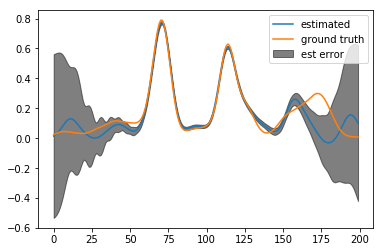

In [36]:
figure()
μ = m.predict_mean0().detach().squeeze().numpy()
σ = m.predict_var0().detach().sqrt().squeeze().numpy()
plot(μ, label='estimated')
fill_between(np.arange(200),μ+σ,μ-σ,color='k',alpha=0.5,label='est error')
plot((data_gen2.mean_A()/data_gen2.n_A).numpy()/2,label='ground truth')
legend()

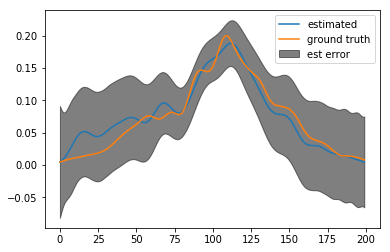

In [37]:
figure()
μ = (m.predict_mean1().detach().reshape(200,200)[:,100]).squeeze().numpy()
σ = (m.predict_var1().detach().reshape(200,200).sqrt()[:,100]).squeeze().numpy()
plot(μ, label='estimated')
fill_between(np.arange(200),μ+σ,μ-σ,color='k',alpha=0.5,label='est error')
plot(((data_gen2.mean_B().reshape(200,200)[:,100])/data_gen2.n_B).numpy()/2,label='ground truth')
legend()

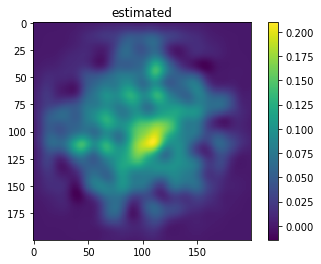

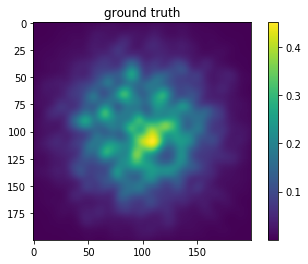

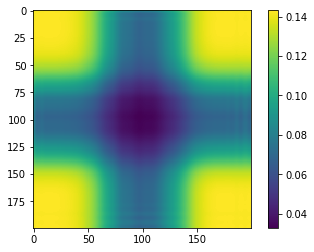

In [38]:
figure()
μ = (m.predict_mean1().detach().reshape(200,200)).numpy()
σ = (m.predict_var1().detach().reshape(200,200).sqrt()).numpy()
imshow(μ)
colorbar()
title('estimated')
figure()
imshow(data_gen2.mean_B().reshape(200,200)/data_gen2.n_B)
title('ground truth')
colorbar()
figure()
imshow(σ)
colorbar()

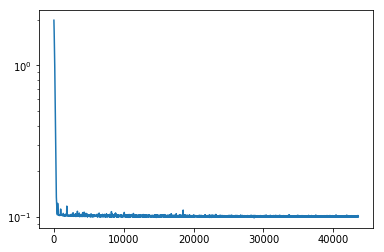

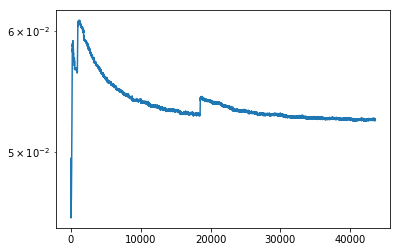

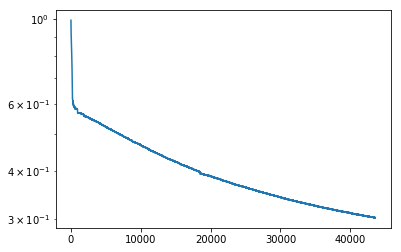

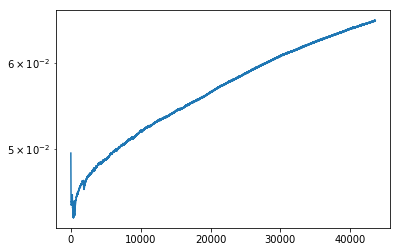

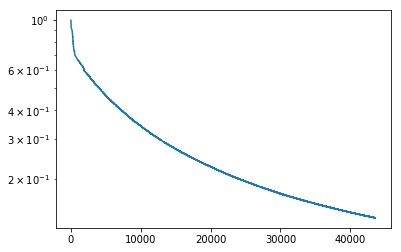

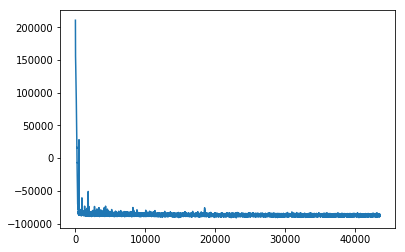

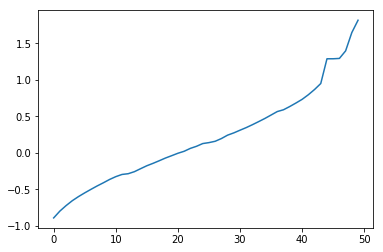

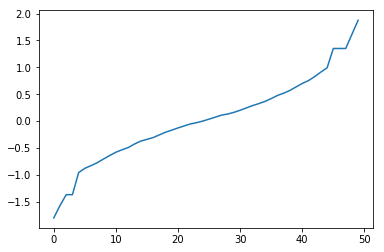

In [39]:
figure()
semilogy(Logger.val_dict['hyper_params.std_lik'])
figure()
semilogy(Logger.val_dict['stored_K.K0._lengthscale_storage'])
figure()
semilogy(Logger.val_dict['stored_K.K0._amplitude_storage'])
figure()
semilogy(Logger.val_dict['stored_K.K1._lengthscale_storage'])
figure()
semilogy(Logger.val_dict['stored_K.K1._amplitude_storage'])
figure()
plot(Logger.val_dict['loss'])
figure()
plot(np.sort(m.hyper_params['u0'].detach().numpy().squeeze()))
figure()
plot(np.sort(m.hyper_params['u1'].detach().numpy().squeeze()))